In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Total Assets": "WALCL",
               "S&P 500": "SP500",
               # Liabilities
               "Total Liabilities" : "WLTLECL",
               # Interest Rates
#                "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Currency in Circulation": "WCURCIR",
#                "VIX": "VIXCLS",
               }

rate_codes = {"Effective Federal Funds Rate (%)": "DFF",
#               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
#                "Federal Funds Upper Target":"DFEDTARU",
#                "Federal Funds Lower Target":"DFEDTARL",
#                "Interest on Reserves (%)": "IOER",
#                 "5 Year Forward Rate": "T5YIFR",
               "Unemployment Rate": "UNRATE",
}


inflation_target = 2

unemployment_target = 4.5
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [2]:
rate_keys = list(rate_codes.keys())
diffs = ["Diff", "Diff-in-Diff"]

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    rate_data = gather_data(rate_codes, start, 
          end = end, freq = freq)
    # transform bil to mil
    data["Currency in Circulation"] = data["Currency in Circulation"].mul(1000)
    data.fillna(0, inplace=True)
    log_data = np.log(data)
    log_diff_data = log_data.diff(year)
    log_diff_data[rate_keys] = rate_data[rate_keys]
    
    # calculate monthly rates as well. This data will be used for ADF and KPSS tests (lags = 12)
    monthly_log_diff_data = log_data.diff()
    monthly_log_diff_data[rate_keys] = rate_data[rate_keys]
    
    data = log_diff_data
    monthly_data = monthly_log_diff_data
    data_gathered = True


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [3]:
for df in [data,monthly_data]:
    df["Currency in Circulation / Total Assets"] = df["Currency in Circulation"].div(df["Total Assets"].mul(1000))
    df["Inflation Loss"]= df["Core PCE"].sub(inflation_target)
    df["Unemployment Loss"]= df["Unemployment Rate"].sub(unemployment_target)
    df["Inflation Loss Sq"]= df["Inflation Loss"].pow(2)
    df["Inflation Loss Sq"][df["Inflation Loss"] < 0] = df["Inflation Loss Sq"][df["Inflation Loss"] < 0] .mul(-1)
    df["Unemployment Loss Sq"]= df["Unemployment Loss"].pow(2)
    df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0] = df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0].mul(-1)
    df["Loss Function"] = df["Inflation Loss Sq"].sub(df["Unemployment Loss Sq"])

In [4]:
data={"Data":data,
     "Diff": data.diff(year).dropna(),
     "Diff-in-Diff": data.diff(year).diff(year).dropna(),
     }
monthly_data={"Data":monthly_data,
     "Diff": monthly_data.diff().dropna(),
     "Diff-in-Diff": monthly_data.diff().diff().dropna(),
     }
diffs = list(data.keys())
for key, val in data.items():
    data[key]["Date"] = val.index.astype(str)

In [6]:
monthly_data_1 = monthly_data["Data"].dropna()
monthly_data_1

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-06-30,0.002643,inf,0.002669,0.001031,0.004409,0.161667,8.2,0.001668,-1.998969,3.7,-3.995877,13.69,-17.685877
2012-07-31,-0.001816,0.020666,-0.001854,0.001030,0.004689,0.156452,8.2,-0.002583,-1.998970,3.7,-3.995881,13.69,-17.685881
2012-08-31,-0.008028,0.031607,-0.008188,0.000629,0.001893,0.132258,8.1,-0.000236,-1.999371,3.6,-3.997483,12.96,-16.957483
2012-09-30,-0.006334,0.028088,-0.006468,0.001238,0.009386,0.144333,7.8,-0.001482,-1.998762,3.3,-3.995050,10.89,-14.885050
2012-10-31,0.002948,-0.003889,0.002994,0.002411,0.007283,0.158387,7.8,0.002471,-1.997589,3.3,-3.990361,10.89,-14.880361
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.011020,-0.021833,0.011090,0.004387,0.004375,0.079355,4.0,0.000397,-1.995613,-0.5,-3.982471,-0.25,-3.732471
2022-02-28,0.008694,-0.030599,0.008731,0.003038,-0.000678,0.080000,3.8,-0.000078,-1.996962,-0.7,-3.987857,-0.49,-3.497857
2022-03-31,0.004064,-0.010131,0.004016,0.003292,0.011378,0.200968,3.6,0.002800,-1.996708,-0.9,-3.986841,-0.81,-3.176841


In [7]:
monthly_data_1 = monthly_data_1.loc['2012-07-31':'2022-04-30']
monthly_data_1

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-07-31,-0.001816,0.020666,-0.001854,0.001030,0.004689,0.156452,8.2,-0.002583,-1.998970,3.7,-3.995881,13.69,-17.685881
2012-08-31,-0.008028,0.031607,-0.008188,0.000629,0.001893,0.132258,8.1,-0.000236,-1.999371,3.6,-3.997483,12.96,-16.957483
2012-09-30,-0.006334,0.028088,-0.006468,0.001238,0.009386,0.144333,7.8,-0.001482,-1.998762,3.3,-3.995050,10.89,-14.885050
2012-10-31,0.002948,-0.003889,0.002994,0.002411,0.007283,0.158387,7.8,0.002471,-1.997589,3.3,-3.990361,10.89,-14.880361
2012-11-30,0.011052,-0.030581,0.011151,0.001084,0.012609,0.160667,7.7,0.001141,-1.998916,3.2,-3.995664,10.24,-14.235664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,0.008660,0.001581,0.008655,0.005084,0.005554,0.079677,3.9,0.000641,-1.994916,-0.6,-3.979690,-0.36,-3.619690
2022-01-31,0.011020,-0.021833,0.011090,0.004387,0.004375,0.079355,4.0,0.000397,-1.995613,-0.5,-3.982471,-0.25,-3.732471
2022-02-28,0.008694,-0.030599,0.008731,0.003038,-0.000678,0.080000,3.8,-0.000078,-1.996962,-0.7,-3.987857,-0.49,-3.497857


In [9]:
monthly_data_2 = monthly_data["Diff"].dropna()
monthly_data_2

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-07-31,-0.004458,-inf,-0.004522,-0.000001,0.000280,-0.005215,0.0,-0.004251,-0.000001,0.0,-0.000004,0.00,-0.000004
2012-08-31,-0.006213,0.010940,-0.006335,-0.000401,-0.002796,-0.024194,-0.1,0.002347,-0.000401,-0.1,-0.001601,-0.73,0.728399
2012-09-30,0.001695,-0.003518,0.001721,0.000608,0.007493,0.012075,-0.3,-0.001246,0.000608,-0.3,0.002432,-2.07,2.072432
2012-10-31,0.009282,-0.031977,0.009461,0.001173,-0.002102,0.014054,0.0,0.003953,0.001173,0.0,0.004690,0.00,0.004690
2012-11-30,0.008104,-0.026692,0.008157,-0.001327,0.005326,0.002280,-0.1,-0.001330,-0.001327,-0.1,-0.005304,-0.65,0.644696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.002360,-0.023414,0.002434,-0.000697,-0.001179,-0.000323,0.1,-0.000244,-0.000697,0.1,-0.002781,0.11,-0.112781
2022-02-28,-0.002327,-0.008766,-0.002359,-0.001349,-0.005054,0.000645,-0.2,-0.000475,-0.001349,-0.2,-0.005386,-0.24,0.234614
2022-03-31,-0.004630,0.020468,-0.004715,0.000254,0.012056,0.120968,-0.2,0.002878,0.000254,-0.2,0.001016,-0.32,0.321016


In [10]:
monthly_data_2 = monthly_data_2.loc['2012-08-31':'2022-04-30']
monthly_data_2

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-08-31,-0.006213,0.010940,-0.006335,-0.000401,-0.002796,-0.024194,-0.1,0.002347,-0.000401,-0.1,-0.001601,-0.73,0.728399
2012-09-30,0.001695,-0.003518,0.001721,0.000608,0.007493,0.012075,-0.3,-0.001246,0.000608,-0.3,0.002432,-2.07,2.072432
2012-10-31,0.009282,-0.031977,0.009461,0.001173,-0.002102,0.014054,0.0,0.003953,0.001173,0.0,0.004690,0.00,0.004690
2012-11-30,0.008104,-0.026692,0.008157,-0.001327,0.005326,0.002280,-0.1,-0.001330,-0.001327,-0.1,-0.005304,-0.65,0.644696
2012-12-31,0.004059,0.050301,0.004380,-0.000359,-0.005951,0.003849,0.2,-0.000700,-0.000359,0.2,-0.001434,1.32,-1.321434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,-0.006738,-0.043711,-0.006768,0.000319,0.001401,0.000011,-0.3,0.000372,0.000319,-0.3,0.001272,-0.27,0.271272
2022-01-31,0.002360,-0.023414,0.002434,-0.000697,-0.001179,-0.000323,0.1,-0.000244,-0.000697,0.1,-0.002781,0.11,-0.112781
2022-02-28,-0.002327,-0.008766,-0.002359,-0.001349,-0.005054,0.000645,-0.2,-0.000475,-0.001349,-0.2,-0.005386,-0.24,0.234614


In [11]:
monthly_data_3 = monthly_data["Diff-in-Diff"].dropna()
monthly_data_3

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-08-31,-0.001754,inf,-0.001813,-0.000399,-0.003077,-0.018978,-1.000000e-01,0.006598,-0.000399,-1.000000e-01,-0.001597,-0.73,0.728403
2012-09-30,0.007907,-0.014459,0.008055,0.001009,0.010289,0.036269,-2.000000e-01,-0.003593,0.001009,-2.000000e-01,0.004034,-1.34,1.344034
2012-10-31,0.007587,-0.028459,0.007741,0.000565,-0.009595,0.001978,3.000000e-01,0.005199,0.000565,3.000000e-01,0.002258,2.07,-2.067742
2012-11-30,-0.001178,0.005286,-0.001304,-0.002501,0.007428,-0.011774,-1.000000e-01,-0.005282,-0.002501,-1.000000e-01,-0.009994,-0.65,0.640006
2012-12-31,-0.004045,0.076993,-0.003777,0.000968,-0.011276,0.001570,3.000000e-01,0.000630,0.000968,3.000000e-01,0.003870,1.97,-1.966130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.009098,0.020297,0.009202,-0.001016,-0.002580,-0.000333,4.000000e-01,-0.000616,-0.001016,4.000000e-01,-0.004054,0.38,-0.384054
2022-02-28,-0.004686,0.014648,-0.004793,-0.000652,-0.003875,0.000968,-3.000000e-01,-0.000231,-0.000652,-3.000000e-01,-0.002604,-0.35,0.347396
2022-03-31,-0.002303,0.029234,-0.002356,0.001603,0.017110,0.120323,4.440892e-16,0.003353,0.001603,4.440892e-16,0.006402,-0.08,0.086402


In [12]:
monthly_data_3 = monthly_data_3.loc['2012-09-30':'2022-04-30']
monthly_data_3

,Total Assets,S&P 500,Total Liabilities,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Unemployment Rate,Currency in Circulation / Total Assets,Inflation Loss,Unemployment Loss,Inflation Loss Sq,Unemployment Loss Sq,Loss Function
DATE,,,,,,,,,,,,,
2012-09-30,0.007907,-0.014459,0.008055,0.001009,0.010289,0.036269,-2.000000e-01,-0.003593,0.001009,-2.000000e-01,0.004034,-1.34,1.344034
2012-10-31,0.007587,-0.028459,0.007741,0.000565,-0.009595,0.001978,3.000000e-01,0.005199,0.000565,3.000000e-01,0.002258,2.07,-2.067742
2012-11-30,-0.001178,0.005286,-0.001304,-0.002501,0.007428,-0.011774,-1.000000e-01,-0.005282,-0.002501,-1.000000e-01,-0.009994,-0.65,0.640006
2012-12-31,-0.004045,0.076993,-0.003777,0.000968,-0.011276,0.001570,3.000000e-01,0.000630,0.000968,3.000000e-01,0.003870,1.97,-1.966130
2013-01-31,0.002946,-0.029977,0.002620,0.001688,0.002217,-0.025785,-1.000000e-01,0.000392,0.001688,-1.000000e-01,0.006746,-0.63,0.636746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,-0.010573,-0.085598,-0.010574,0.000257,0.000690,-0.000624,1.000000e-01,0.000400,0.000257,1.000000e-01,0.001026,-0.17,0.171026
2022-01-31,0.009098,0.020297,0.009202,-0.001016,-0.002580,-0.000333,4.000000e-01,-0.000616,-0.001016,4.000000e-01,-0.004054,0.38,-0.384054
2022-02-28,-0.004686,0.014648,-0.004793,-0.000652,-0.003875,0.000968,-3.000000e-01,-0.000231,-0.000652,-3.000000e-01,-0.002604,-0.35,0.347396


In [13]:
monthly_data={"Data":monthly_data_1,
     "Diff": monthly_data_2,
     "Diff-in-Diff": monthly_data_3
     }

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *
from statsmodels.tsa.adfvalues import *
import warnings
warnings.simplefilter("ignore")
import statsmodels
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)

from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InfeasibleTestError,
    InterpolationWarning,
    MissingDataError,
)


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


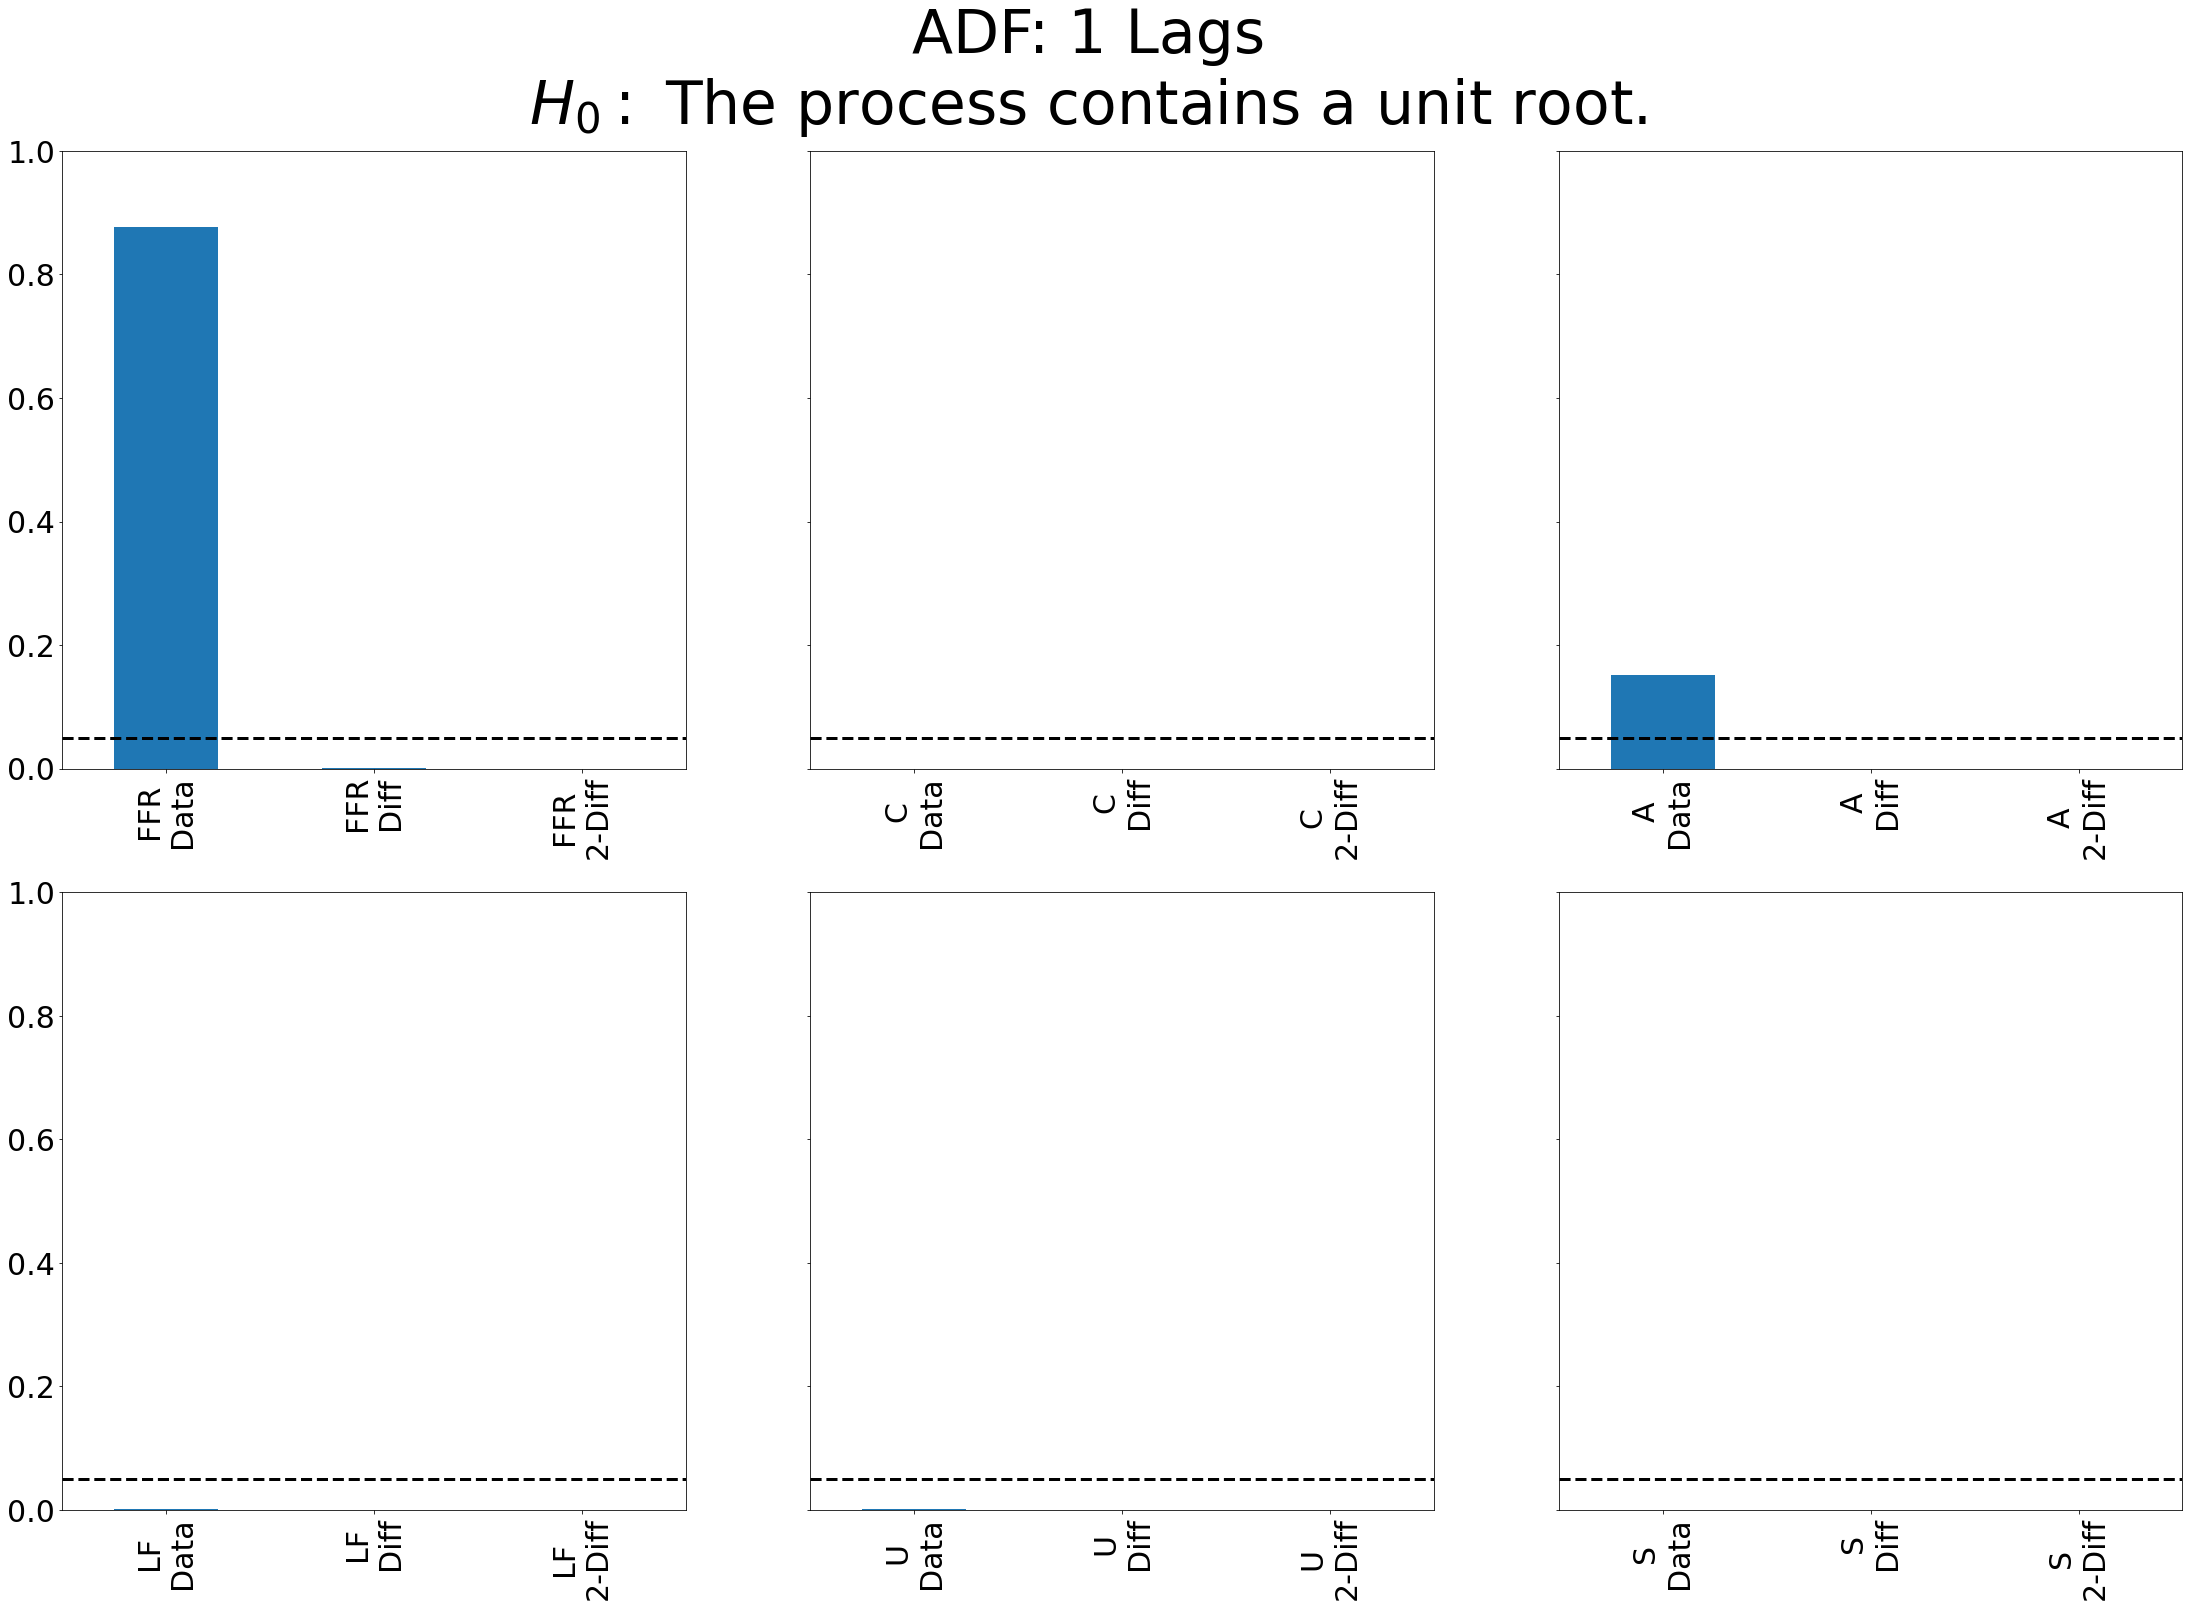

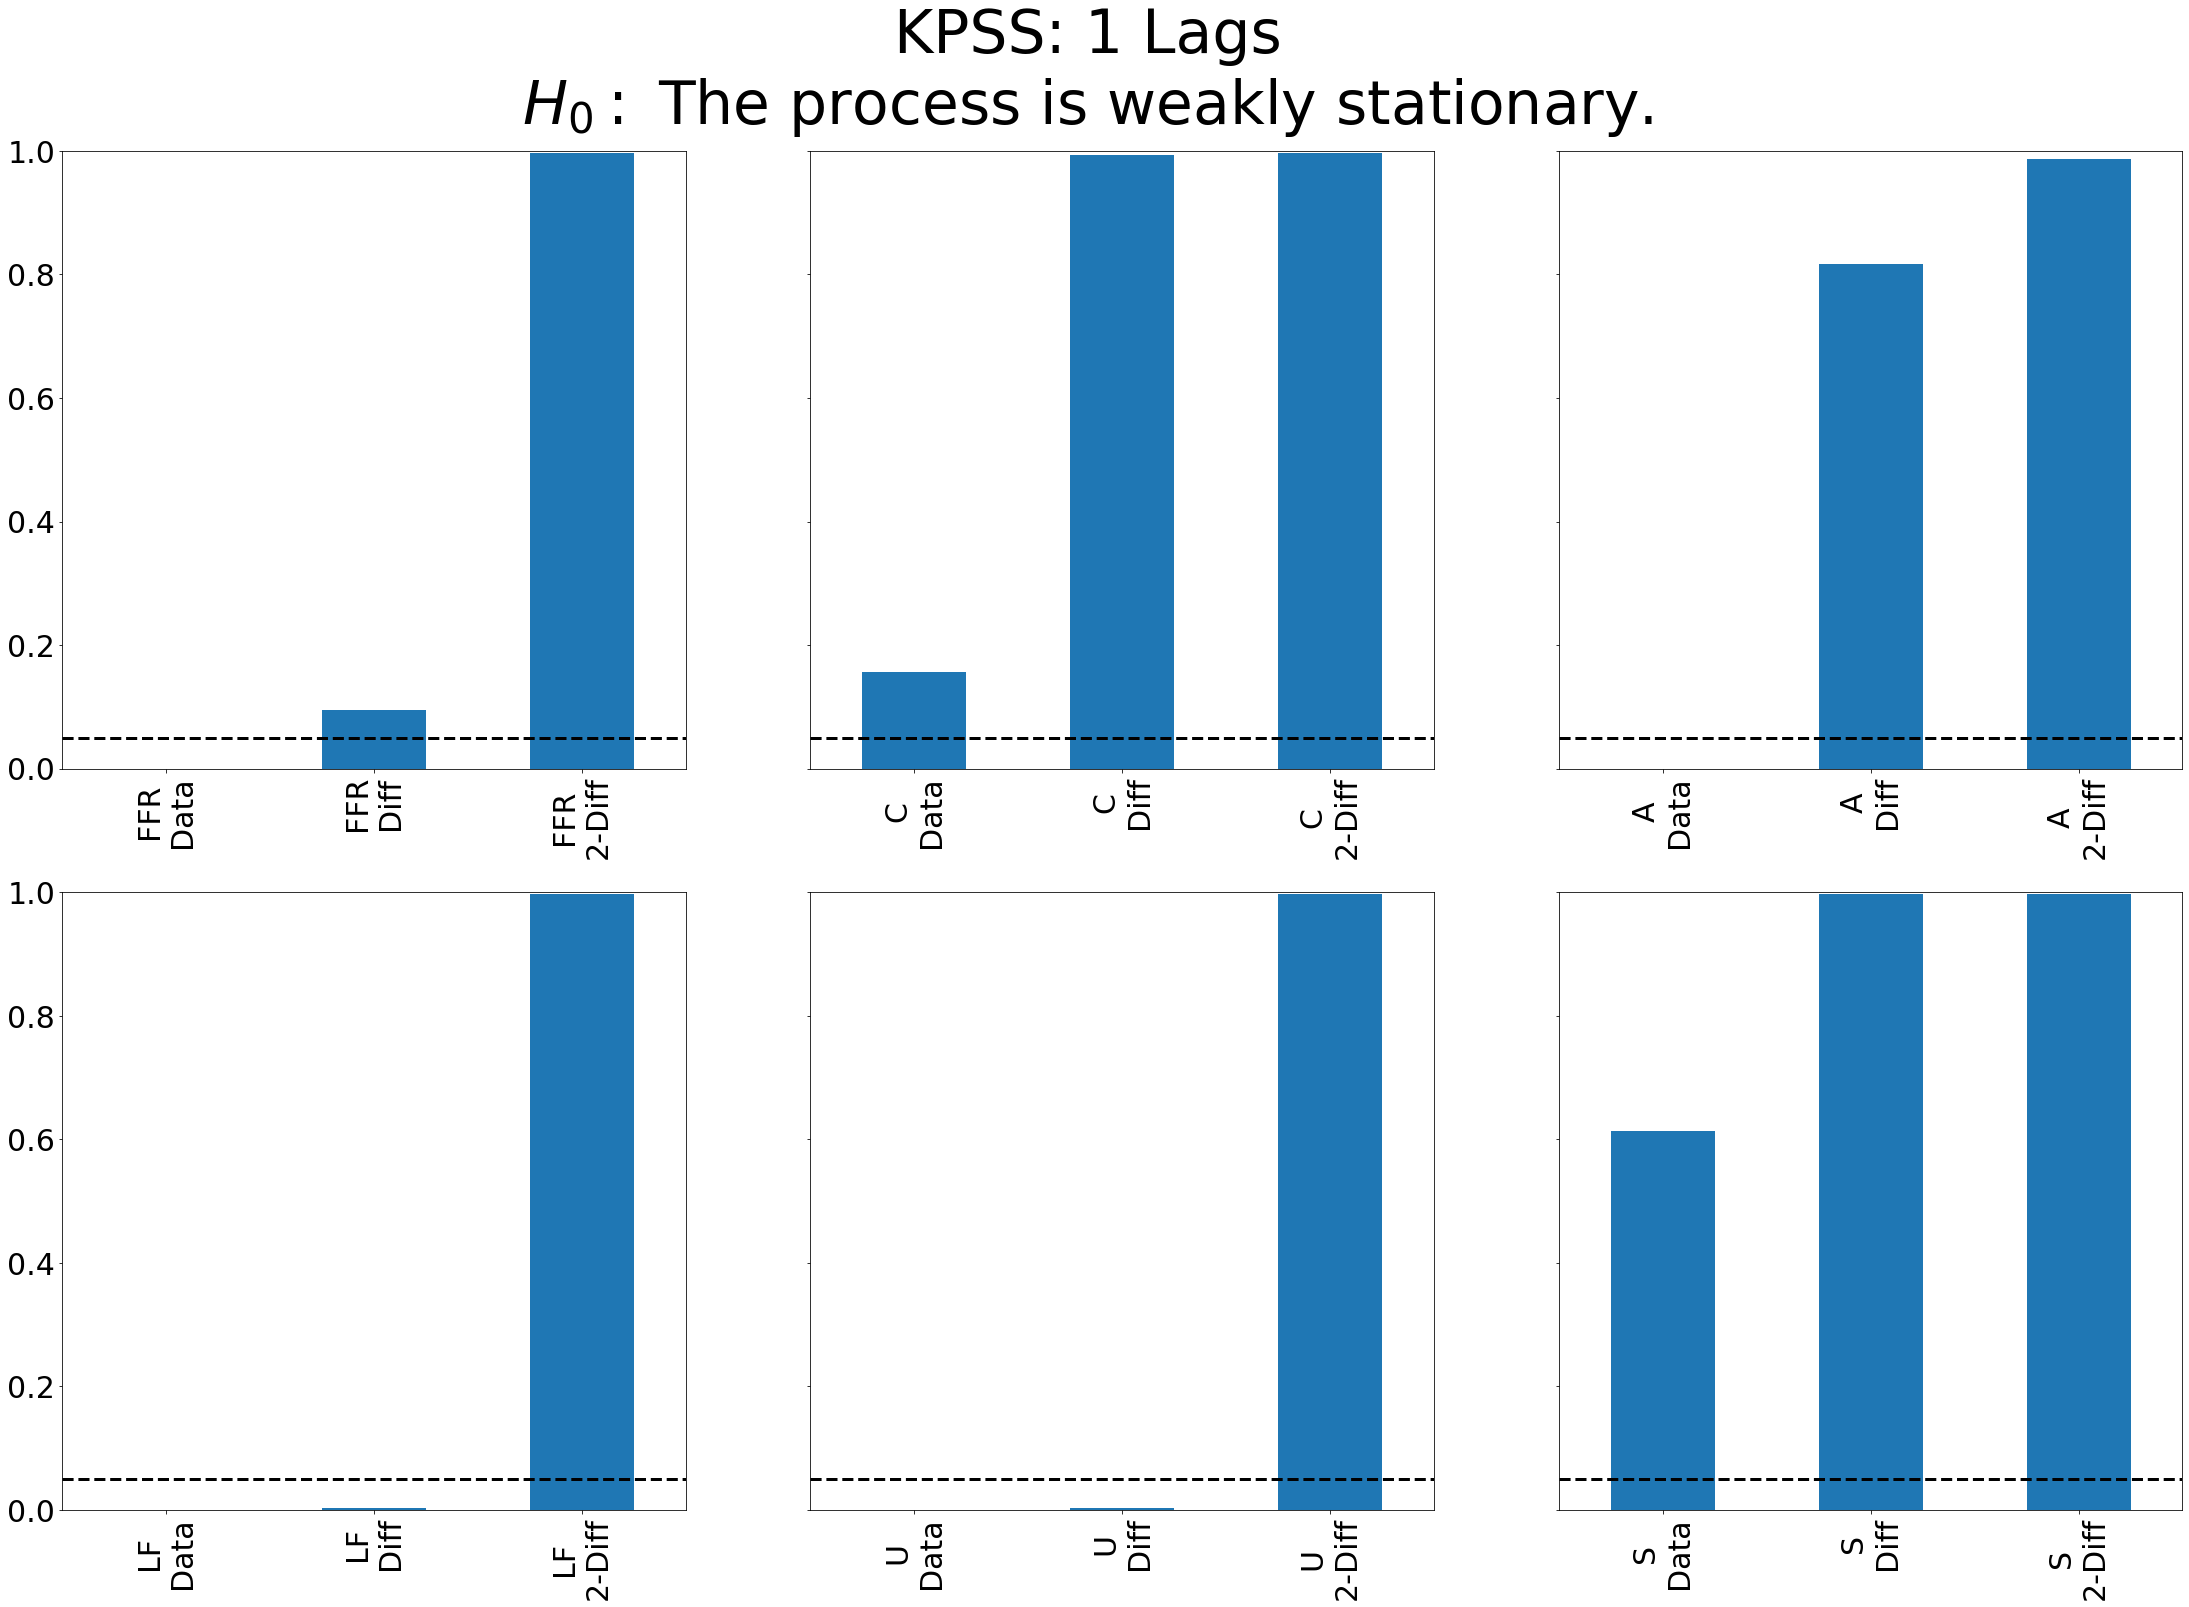

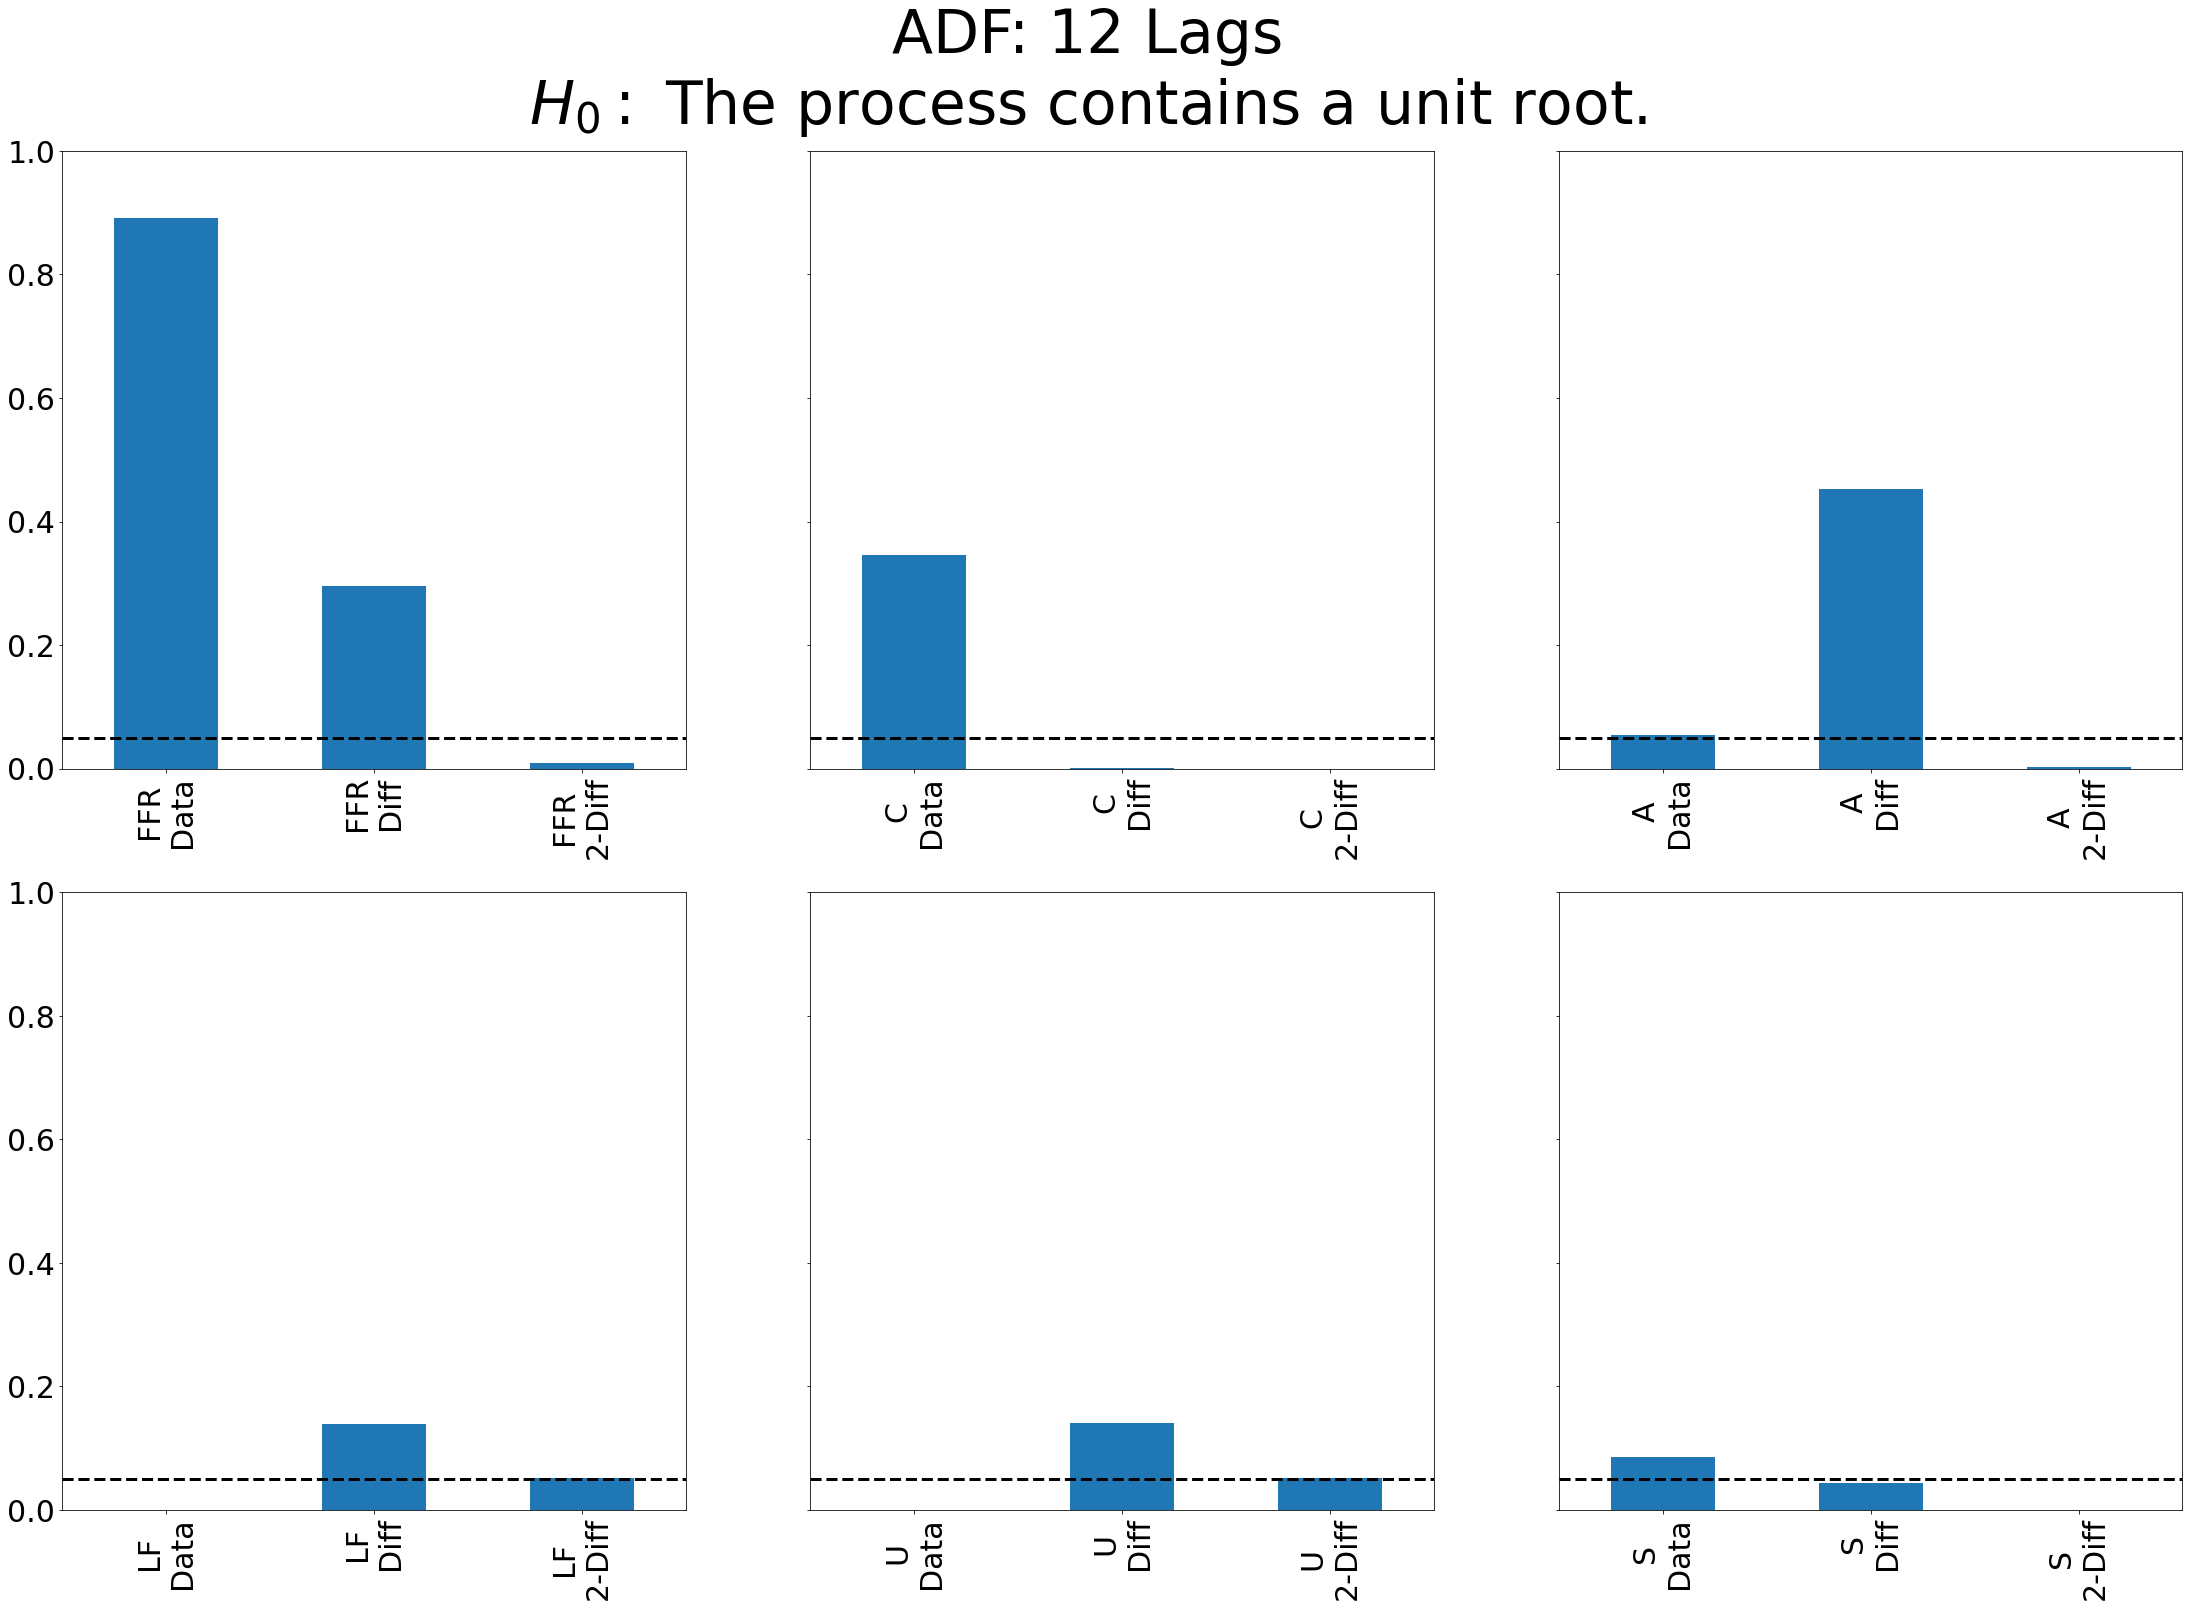

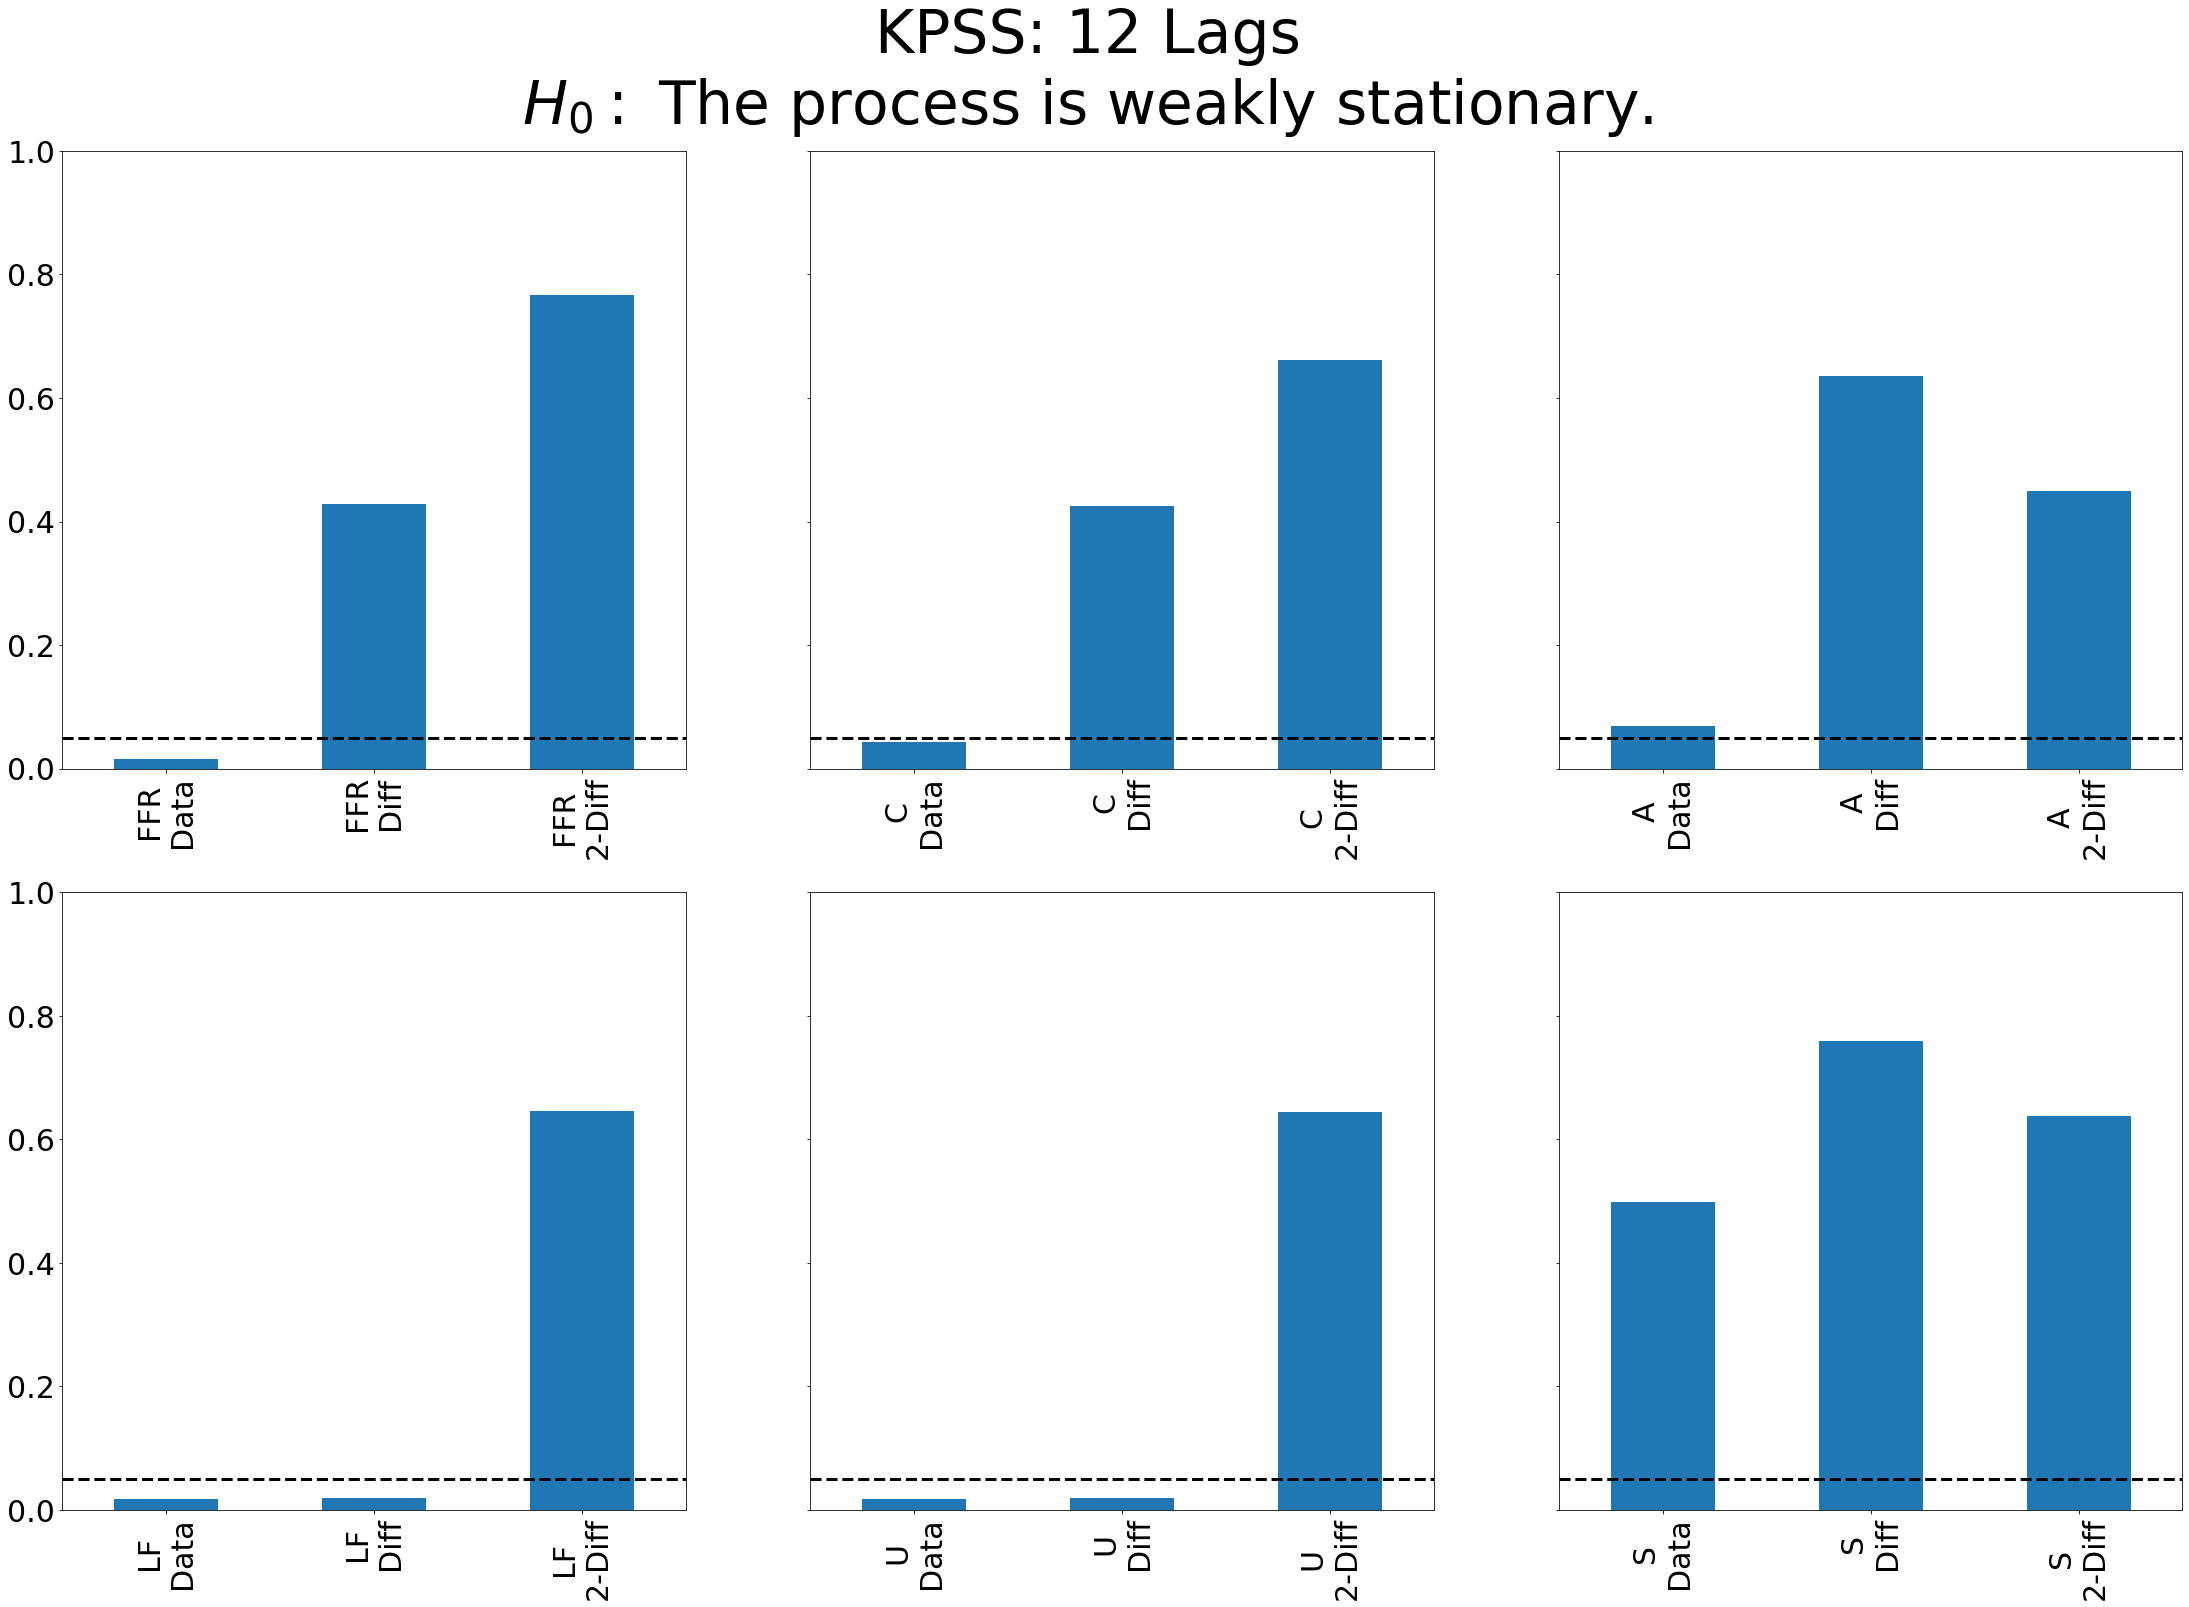

In [15]:
def run_ts_tests(data_dct, lags, adf_dct = {}, kpss_dct = {}):
    def build_result_dcts(): 
        for key in keys:
            adf_dct[key] = {}
            kpss_dct[key] = {}
            for diff in diffs:
                adf_dct[key][diff] = {}
                kpss_dct[key][diff] = {}   
        return adf_dct, kpss_dct
    
    diffs = list(data_dct.keys())
    keys = list(data_dct[diffs[0]].keys())
    build_result_dcts()
    for diff in diffs:
        test_data = data_dct[diff][list(rename_dct.values())]
        test_data.dropna().to_csv("TestData"+diff+".csv")
        test_data = test_data.loc[:"2020-02-29"].dropna()
        for key, val in test_data.items():  
            adf_dct[key][diff] = ADF(val, 
                                       lags = lags, 
                                       trend= "c").pvalue
            kpss_dct[key][diff] = KPSS(val, 
                                       lags = lags, 
                                       trend= "c").pvalue            
    return pd.DataFrame(adf_dct), pd.DataFrame(kpss_dct)

def bar_plots(dct, width = 2, length = 3,title = "", title_y = 1):
    
    fig, ax = plt.subplots(width,
                           length, 
                           figsize = (38,25))
    i = 0
    j = 0
    for key, df in dct.items():
        df.plot.bar(ax = ax[j][i],
                              legend = False)
        xtick_labels = ax[j][i].get_xticks()
        ax[j][i].axhline(.05, ls = "--", color = "k", linewidth = 3)
        ax[j][i].set_xticklabels([key + "\n" + diff.replace("Diff-in-Diff","2-Diff") for diff in diffs],
                                fontsize = 30)
        ax[j][i].set_ylim(0,1)

        if i == 0:
            ax[j][i].set_yticklabels([round(y,2) for y in ax[j][i].get_yticks()],
                                fontsize = 30)
        else:
            ax[j][i].set_yticklabels(["" for y in ax[j][i].get_yticks()])

        i+=1

        if i == length:
            i = 0
            j += 1
        #     if i == 2 and j == 1:
        #         ax[j][i].set_axis_off()
    fig.suptitle(title, y = title_y, fontsize = 60)
    fig.savefig(title.replace(":", "-").replace("$","").replace("\n","") + ".png")
    
    

rename_dct = {"Effective":"FFR",
#              "Circulation / Total":"C/A",
              "Circulation":"C",
             "Assets":"A",
              "Function":"LF",
             "Unemployment":"U",
             "S&P 500" : "S"}
abbrev_keys = list(rename_dct.values())
lags = 1
# lags = year


        
    
for diff in diffs:
    # test all variables, include loss fucntion components
    test_vars = ["Effective Federal Funds Rate (%)",
        "Currency in Circulation",
        "Total Assets",
        "Loss Function",
                 "S&P 500",
        "Unemployment Loss Sq"]
#     adf_data = monthly_data[diff][test_vars]
    for key in test_vars:
        for rename_key in rename_dct:
            if rename_key in key:
                monthly_data[diff].rename(columns={key:rename_dct[rename_key] for rename_key in rename_dct if rename_key in key},
                                inplace = True) 
                
test_data = copy.copy(monthly_data)
for diff in test_data.keys():
    test_data[diff] = test_data[diff][abbrev_keys].dropna().loc[:"2020-02-29"]
for lags in [1,12]:
    adf_df, kpss_df = run_ts_tests(test_data, lags)
    # plot_ADF tests
    # create filler val to get null hypothesis
    val = [i for i in range(10)]
    title = "ADF: " + str(lags) + " Lags\n$H_0:$ "+ ADF(val,
                       lags = lags,
                       trend = "c").null_hypothesis 
    title_y = .96
    bar_plots(adf_df, title = title, title_y = title_y)

    # plot KPSS tests
    title = "KPSS: " + str(lags) + " Lags\n$H_0:$ "+  KPSS(val,
                           lags = lags,
                           trend = "c").null_hypothesis 
    bar_plots(kpss_df, title = title, title_y = title_y)

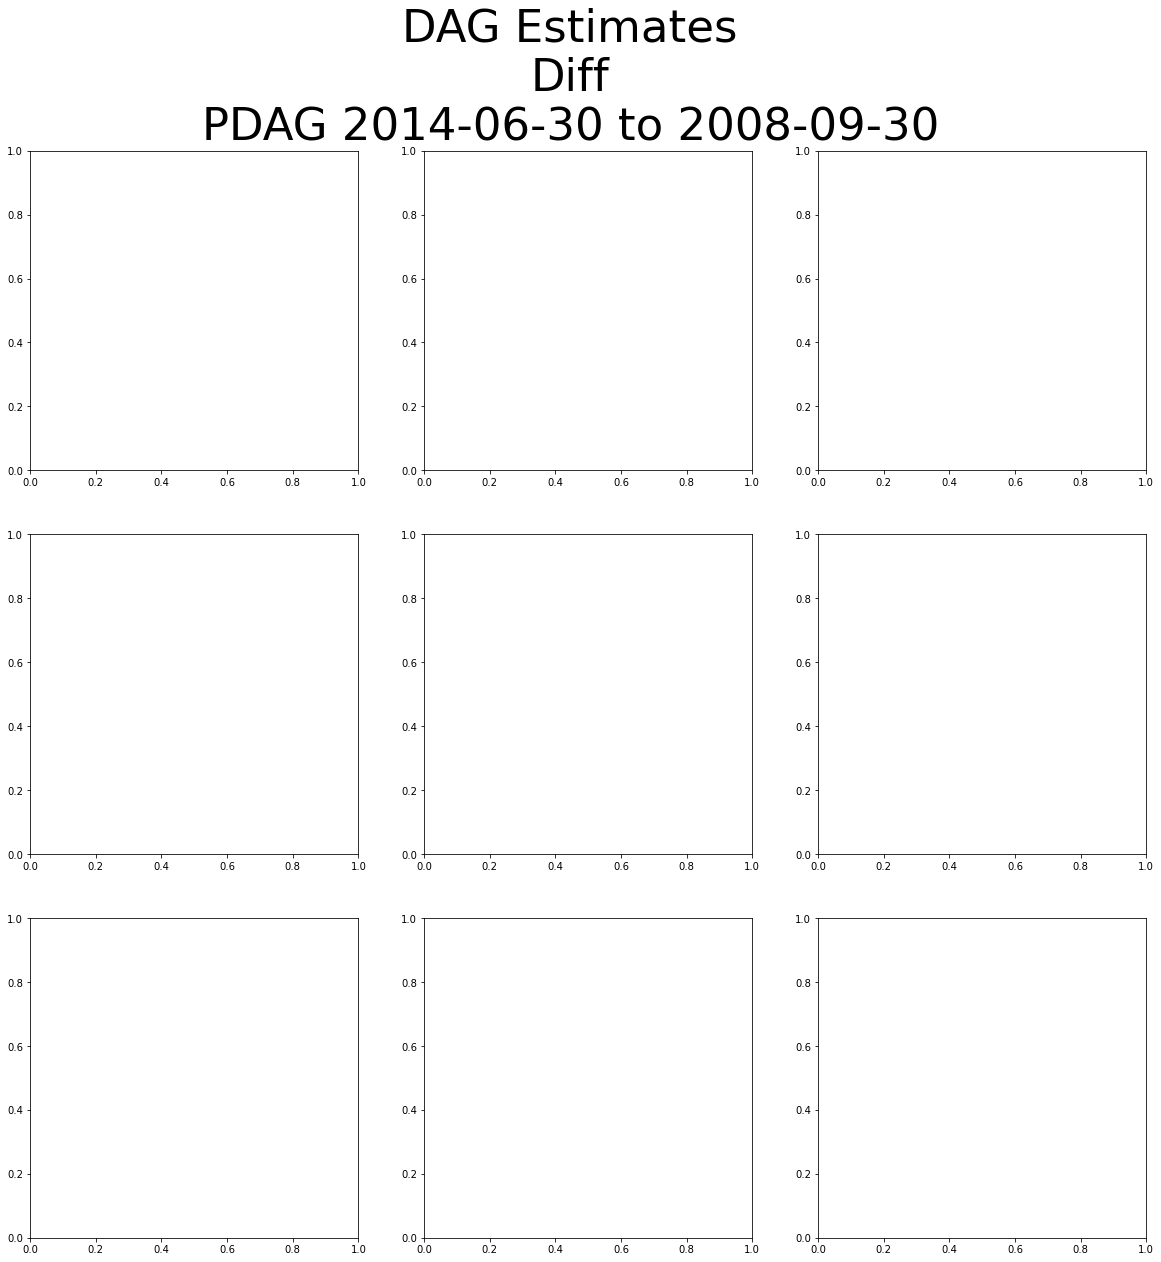

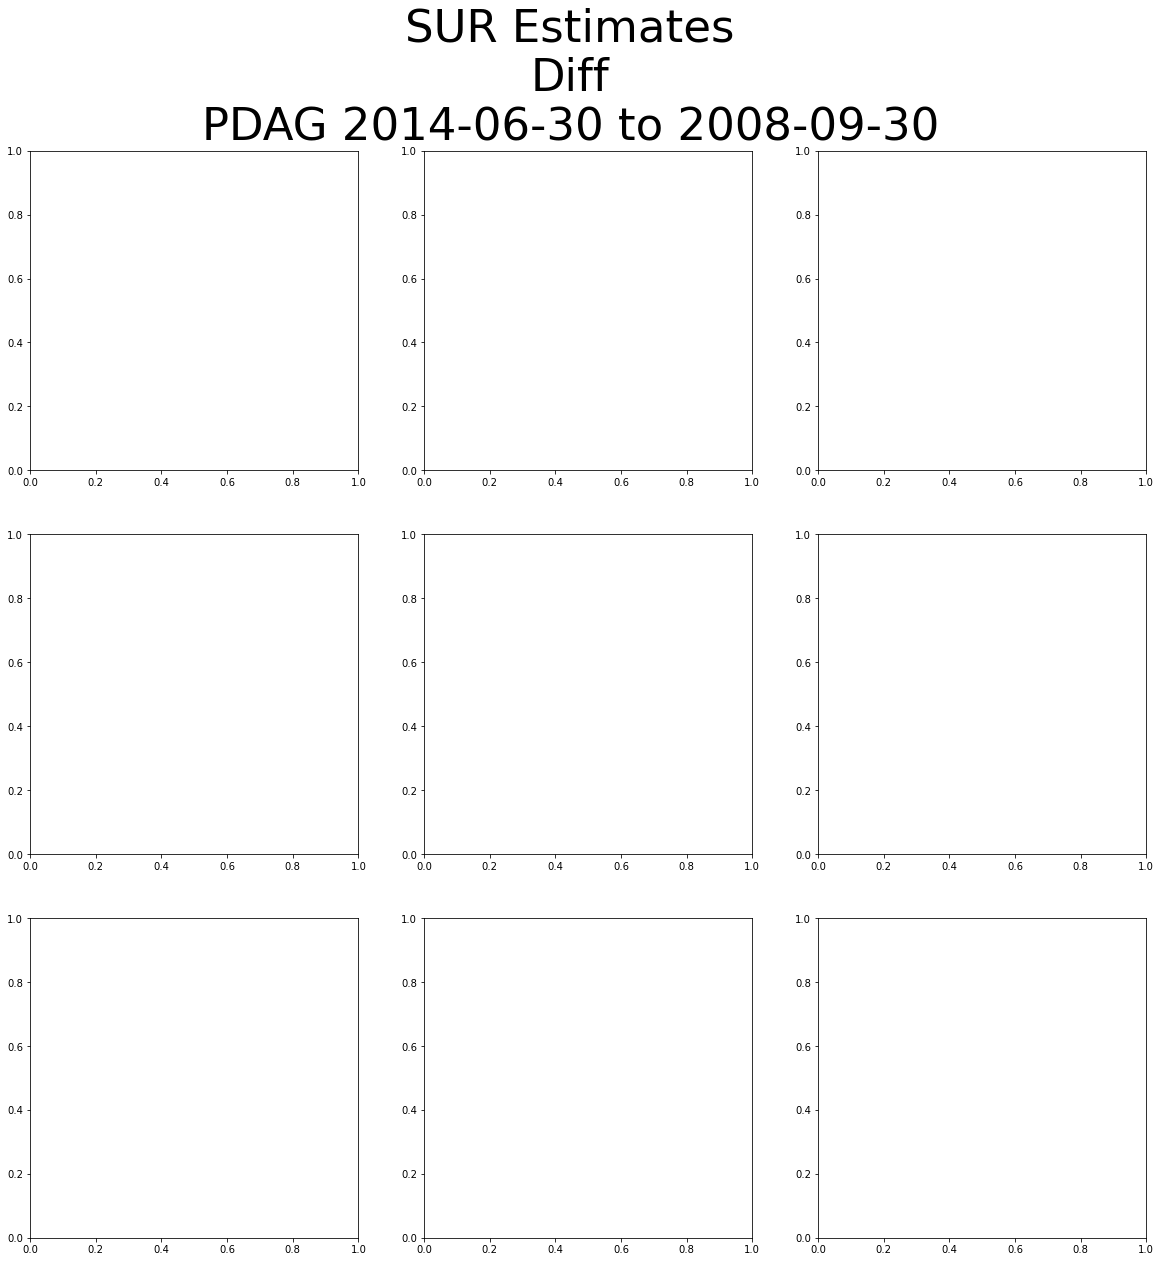

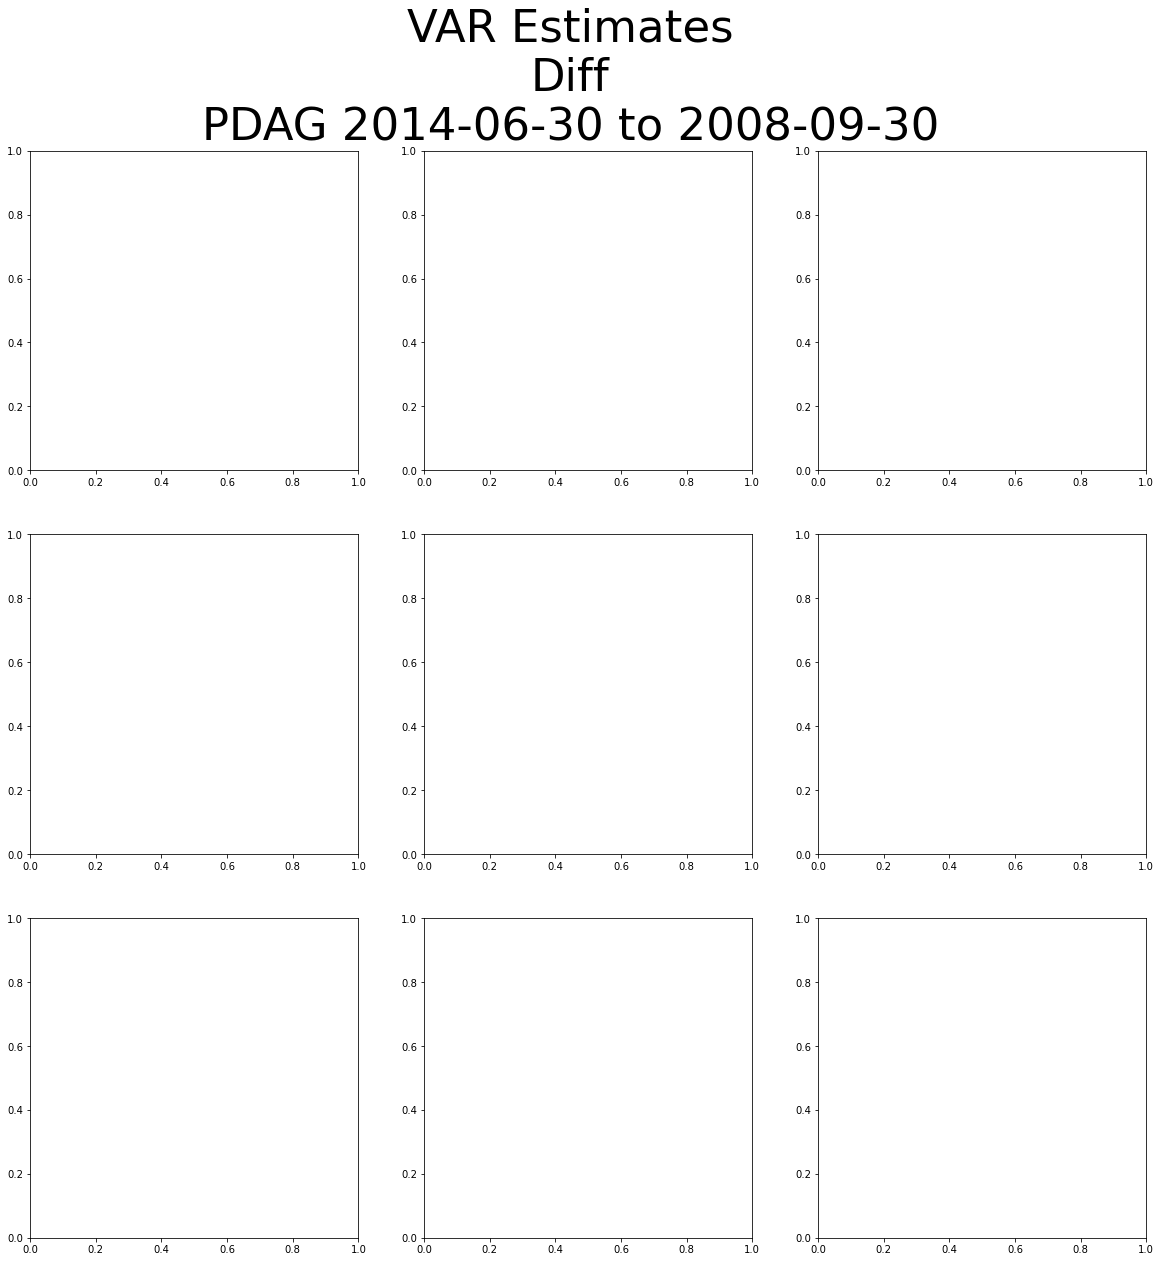

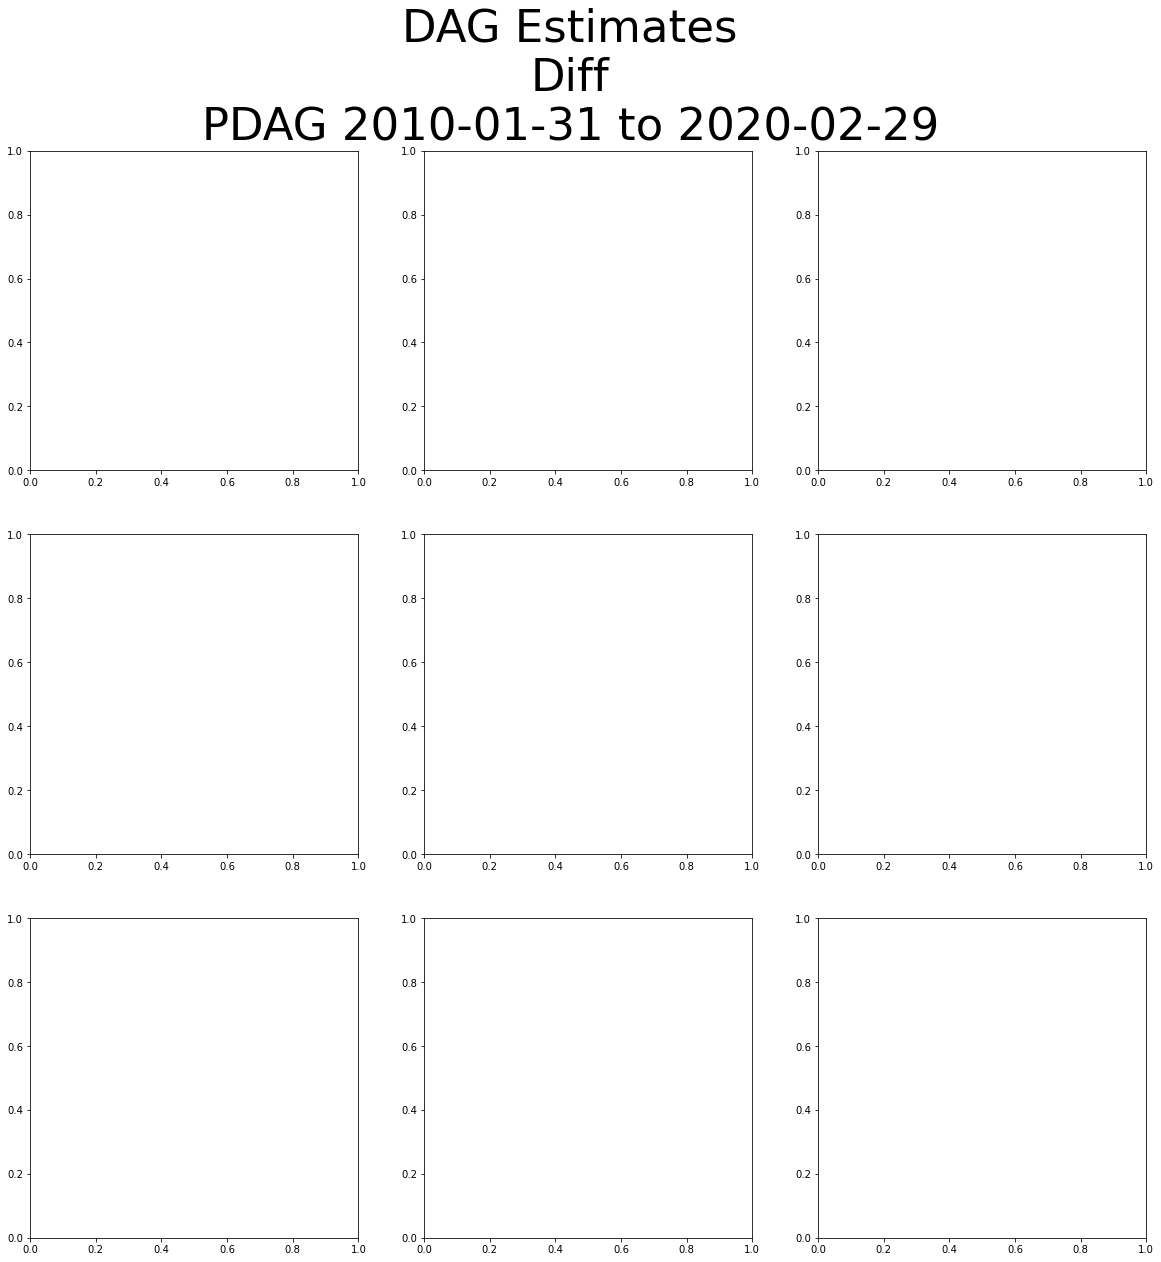

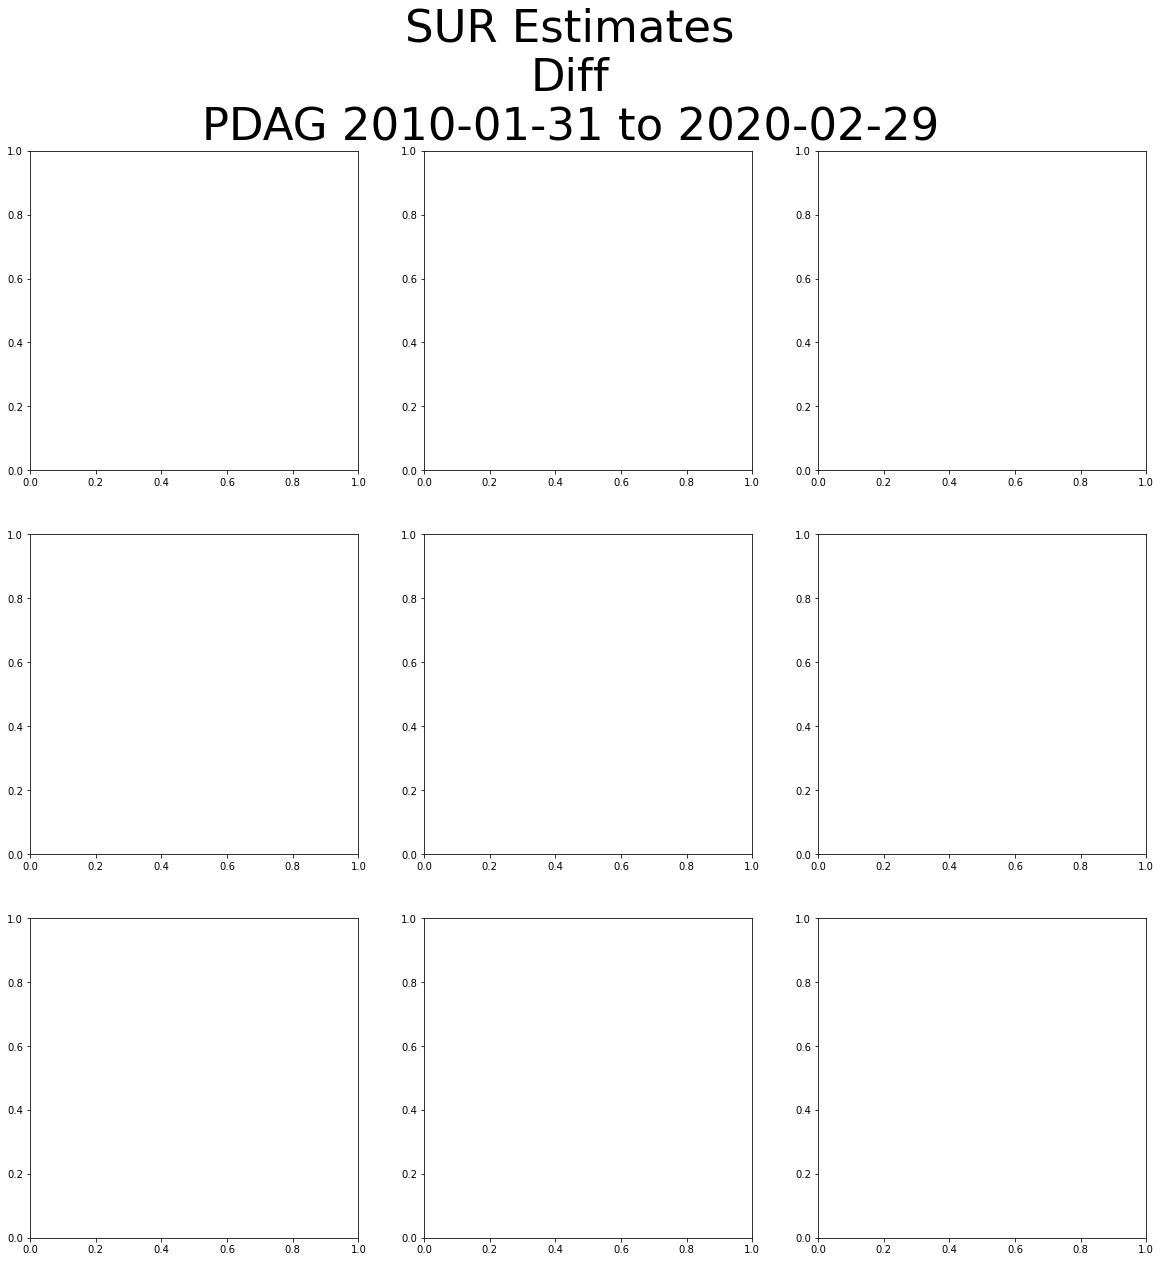

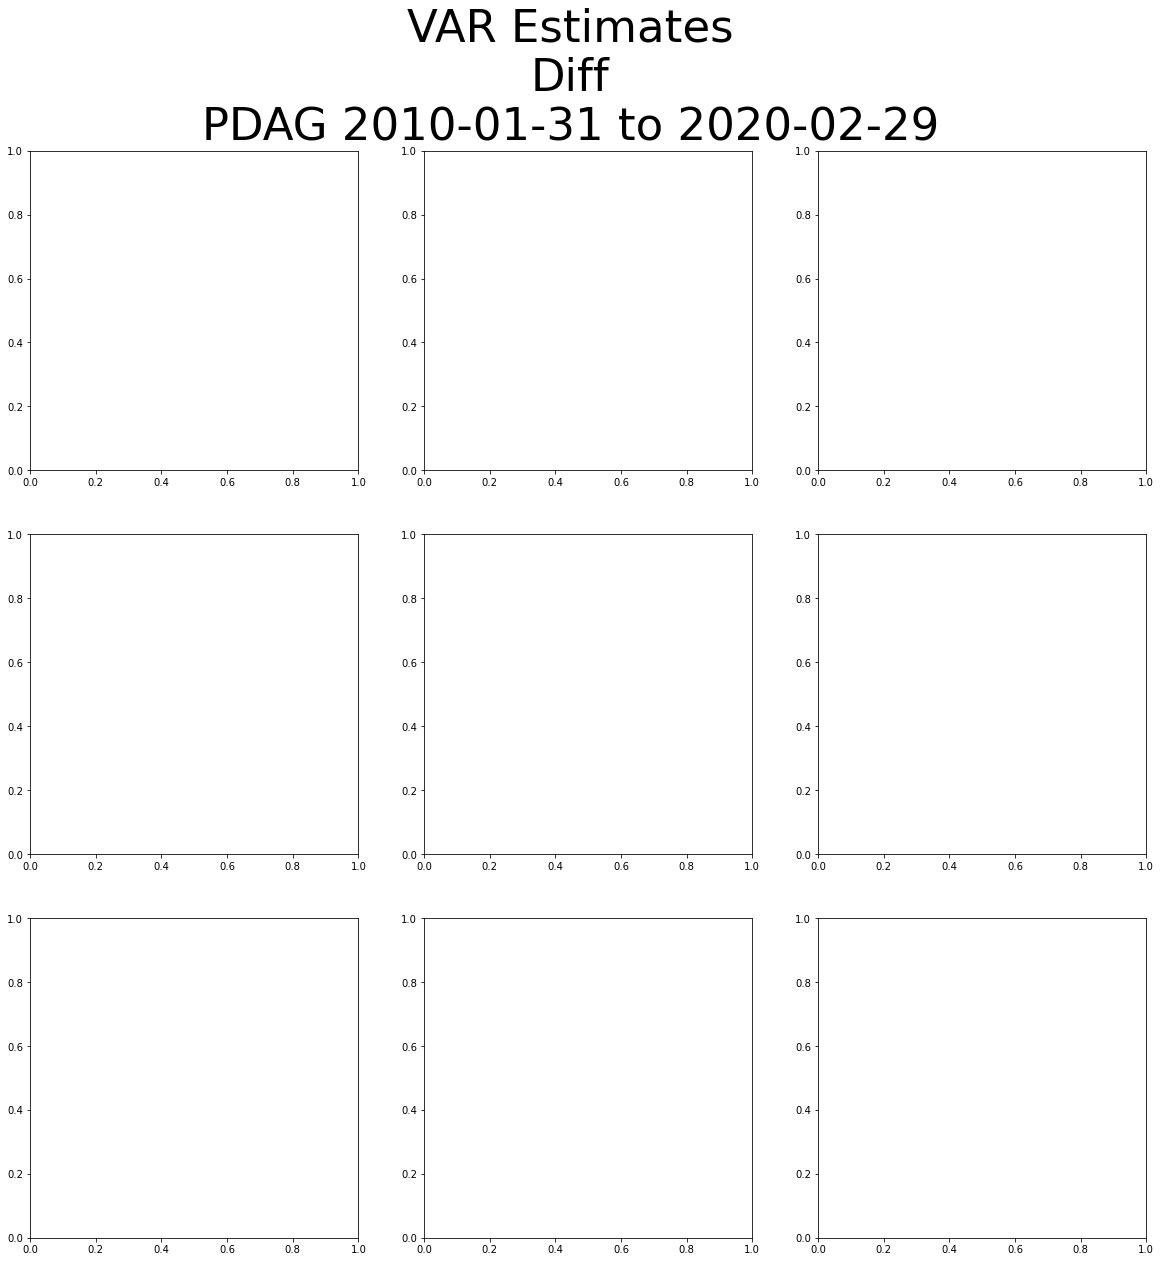

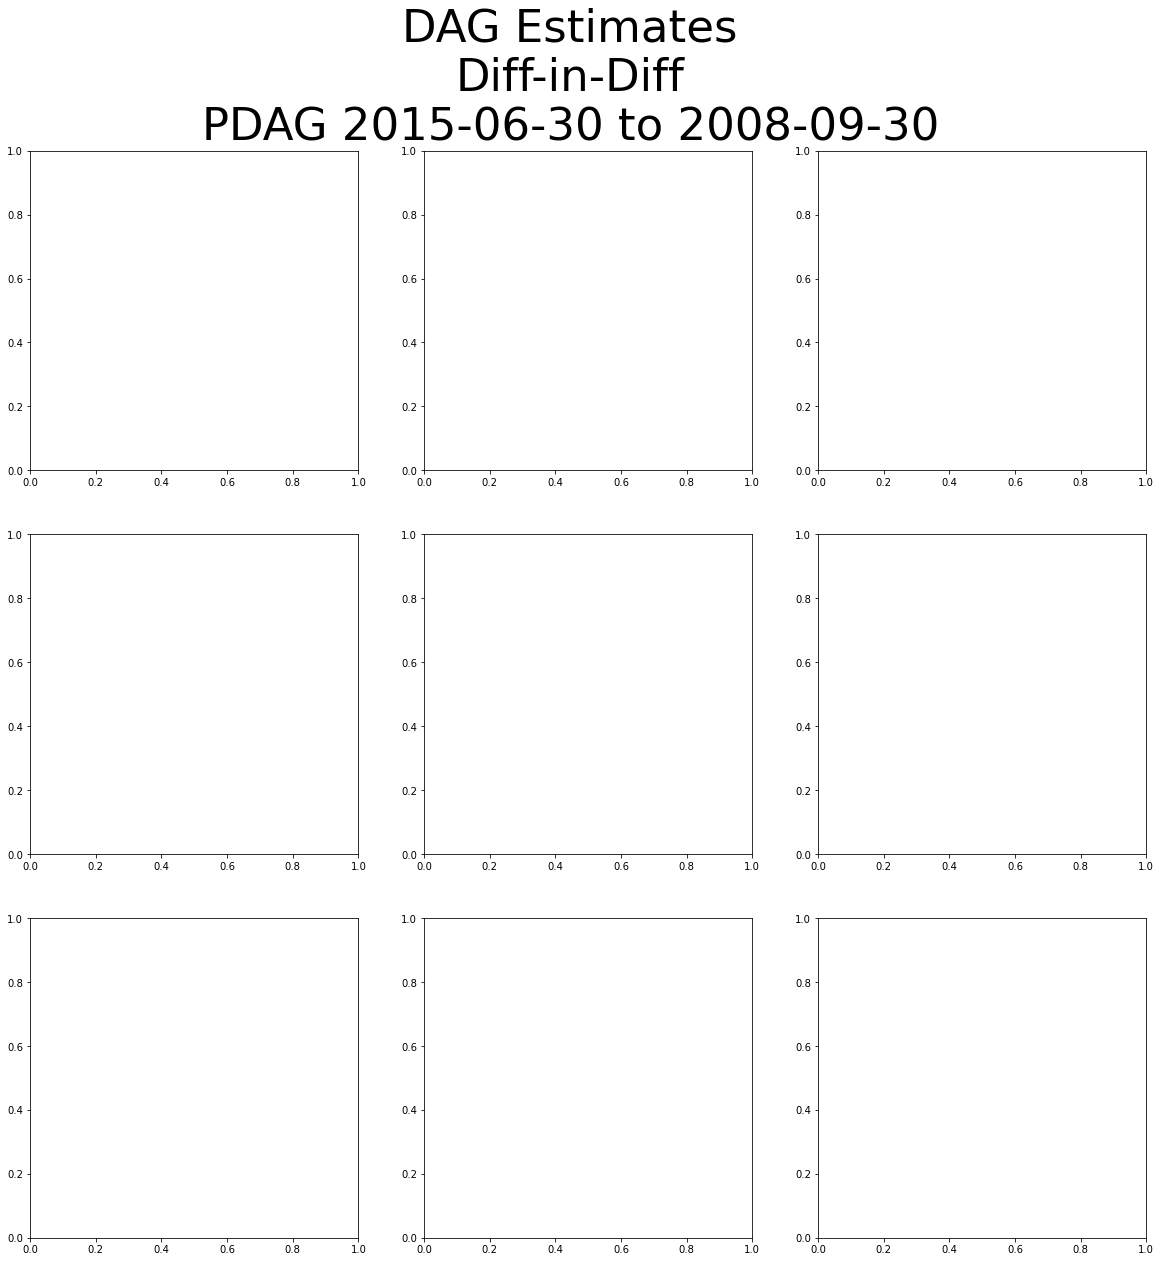

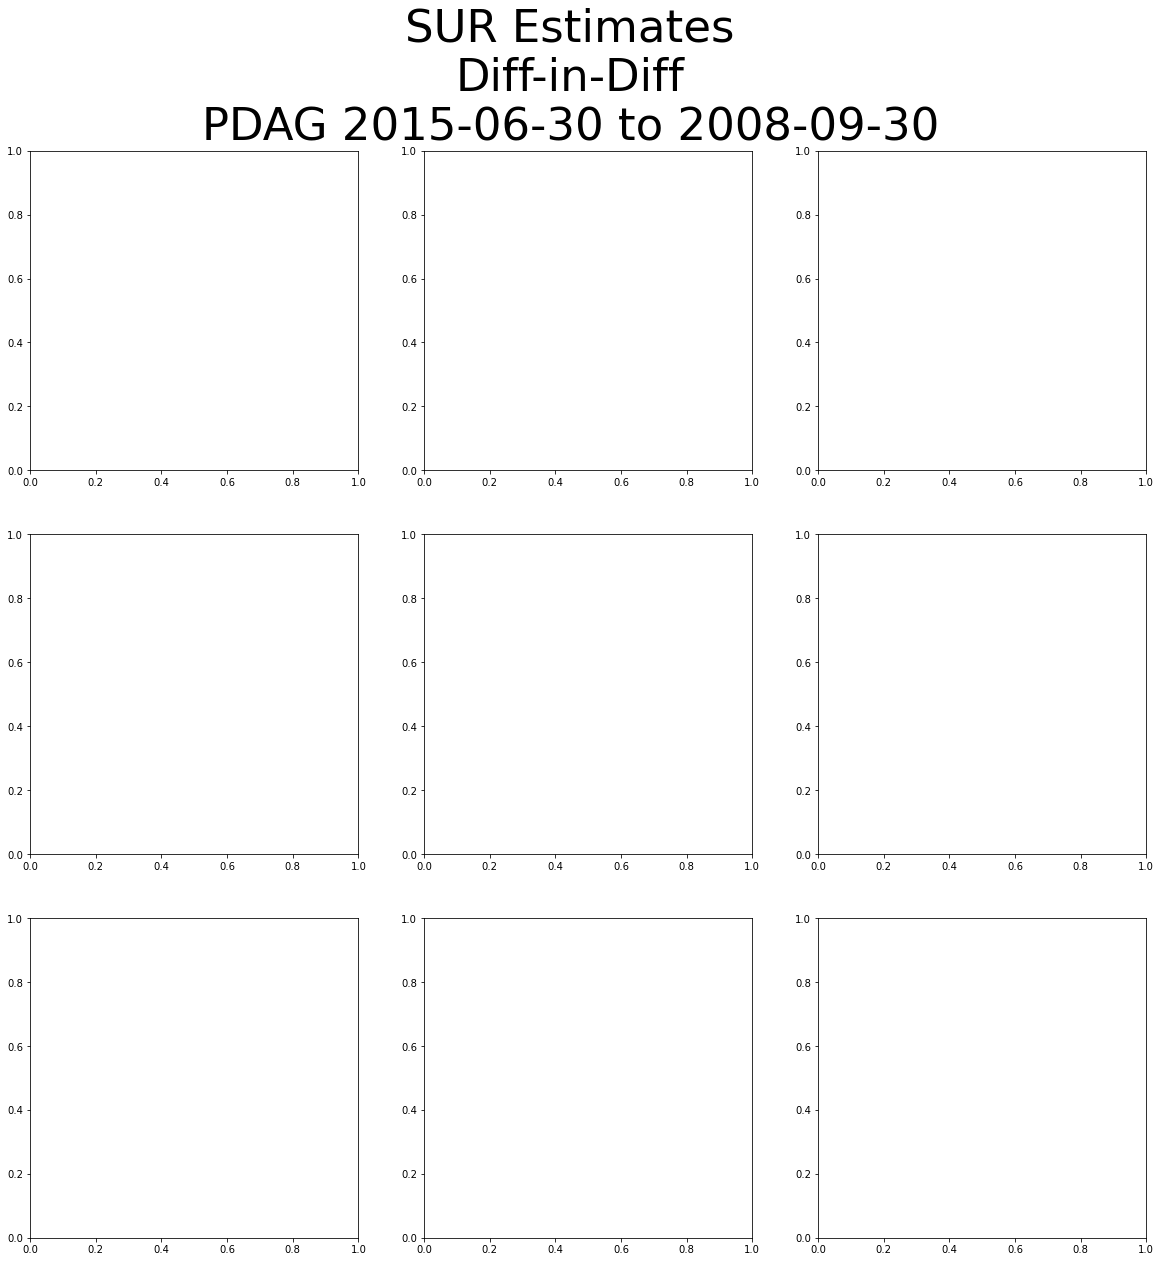

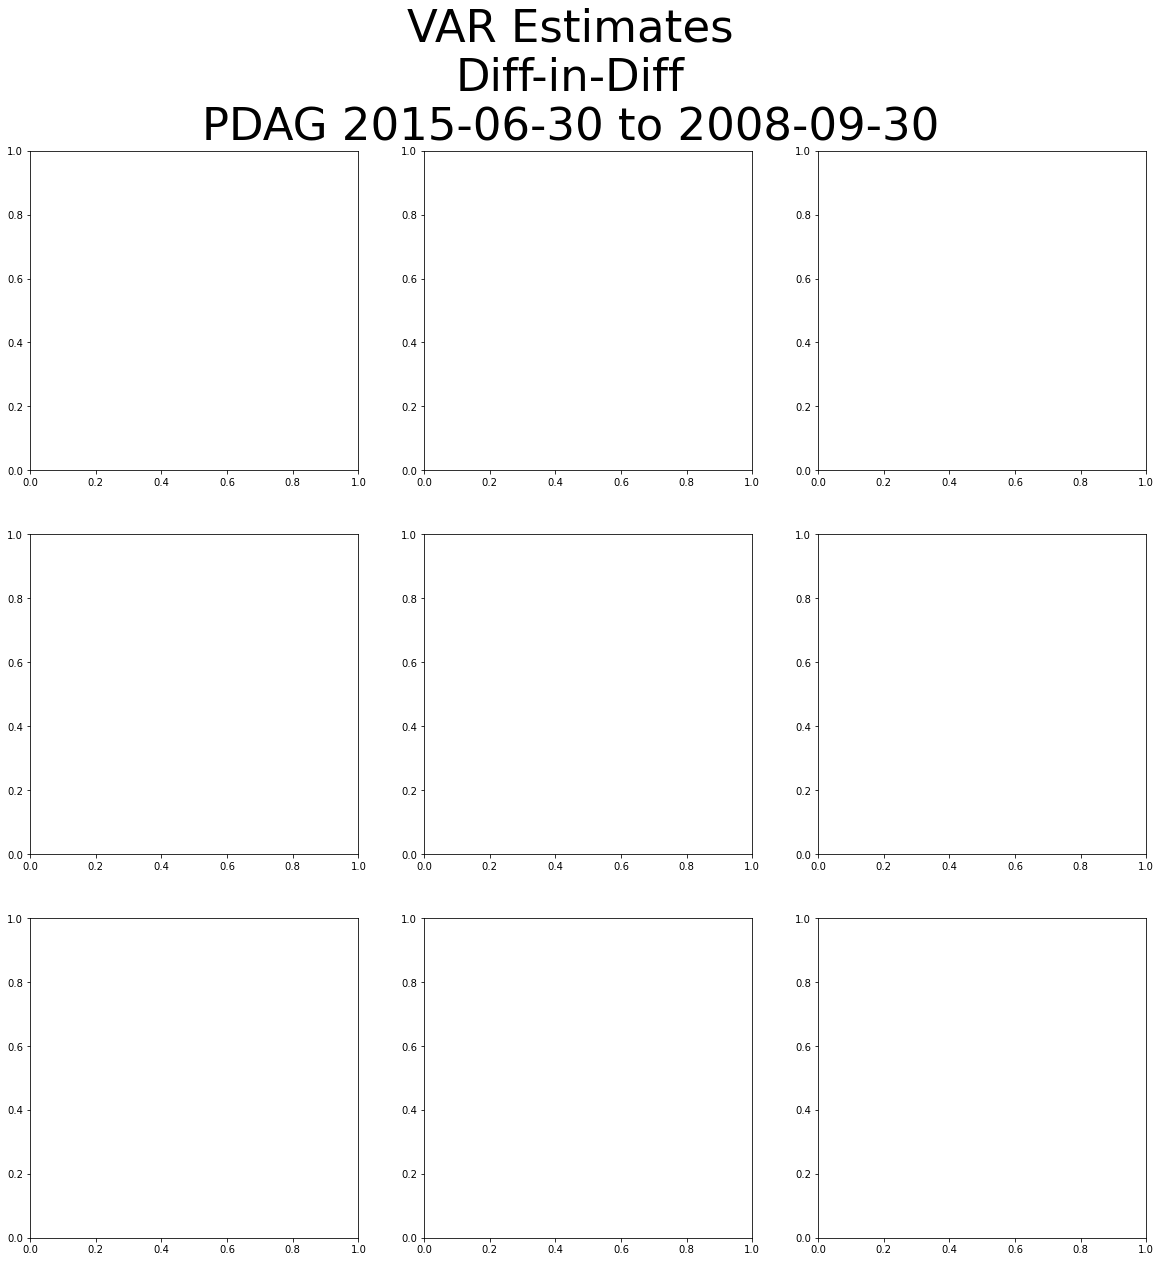

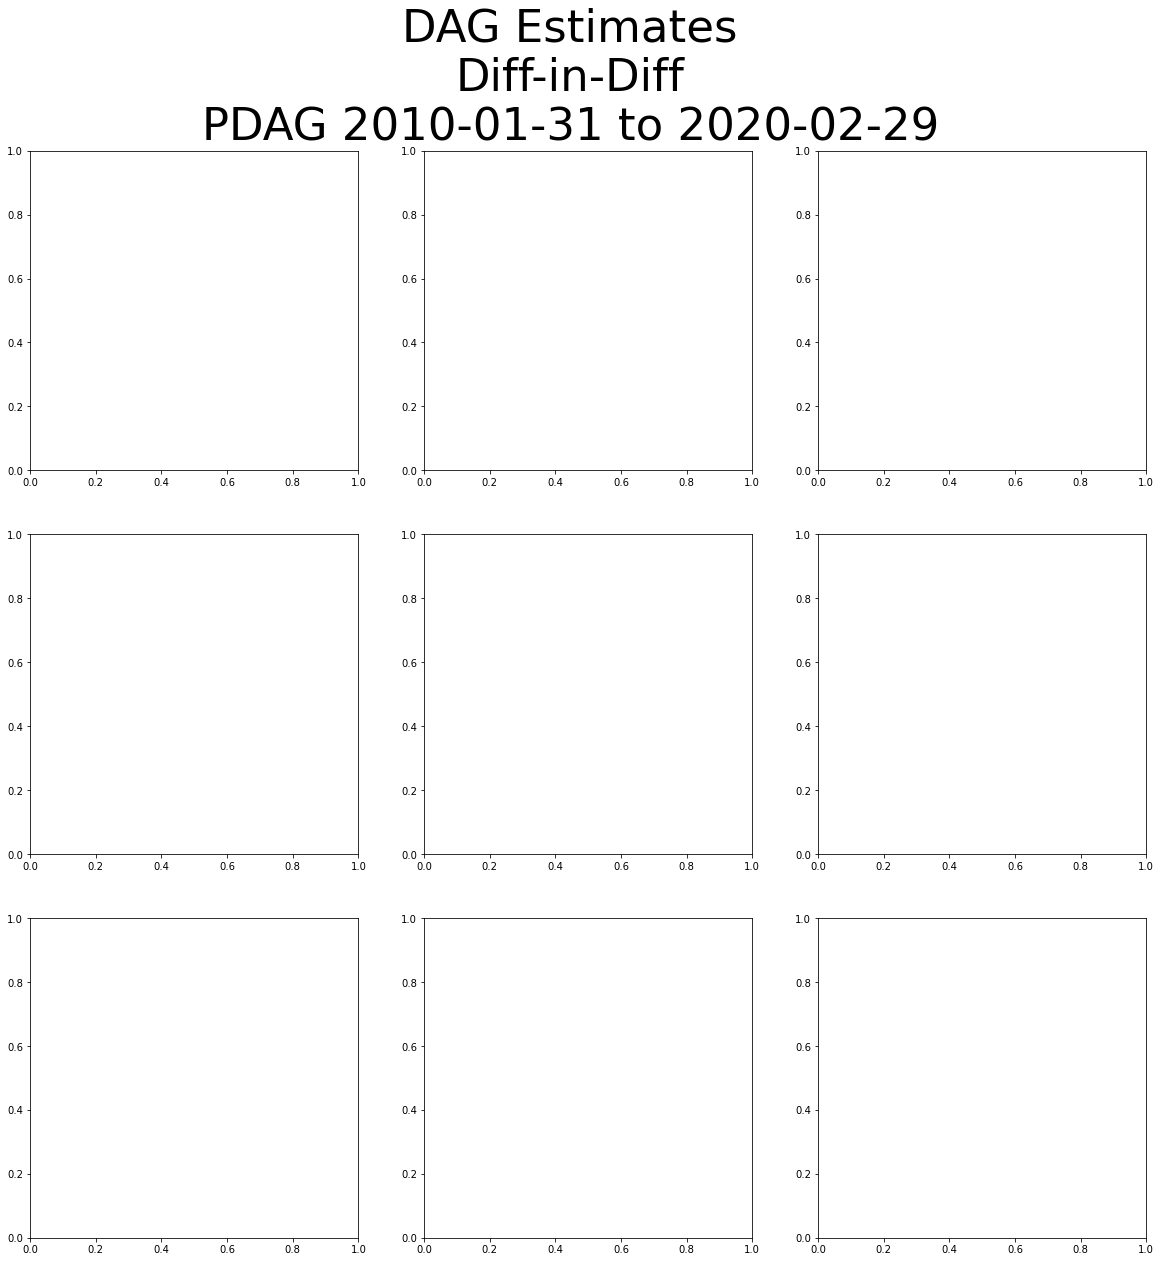

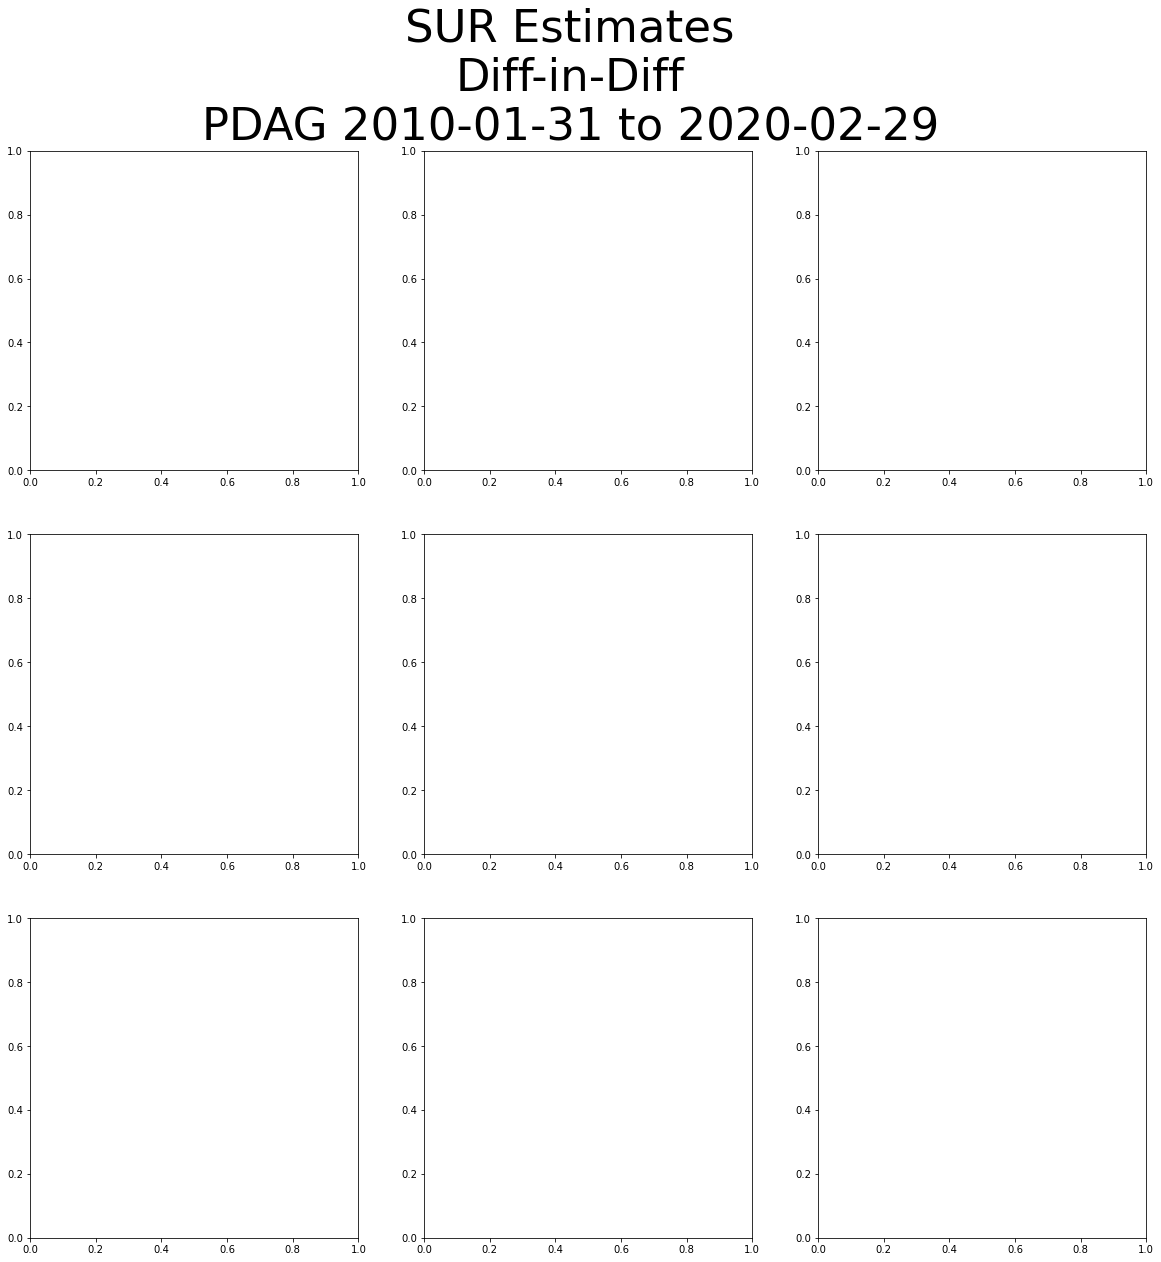

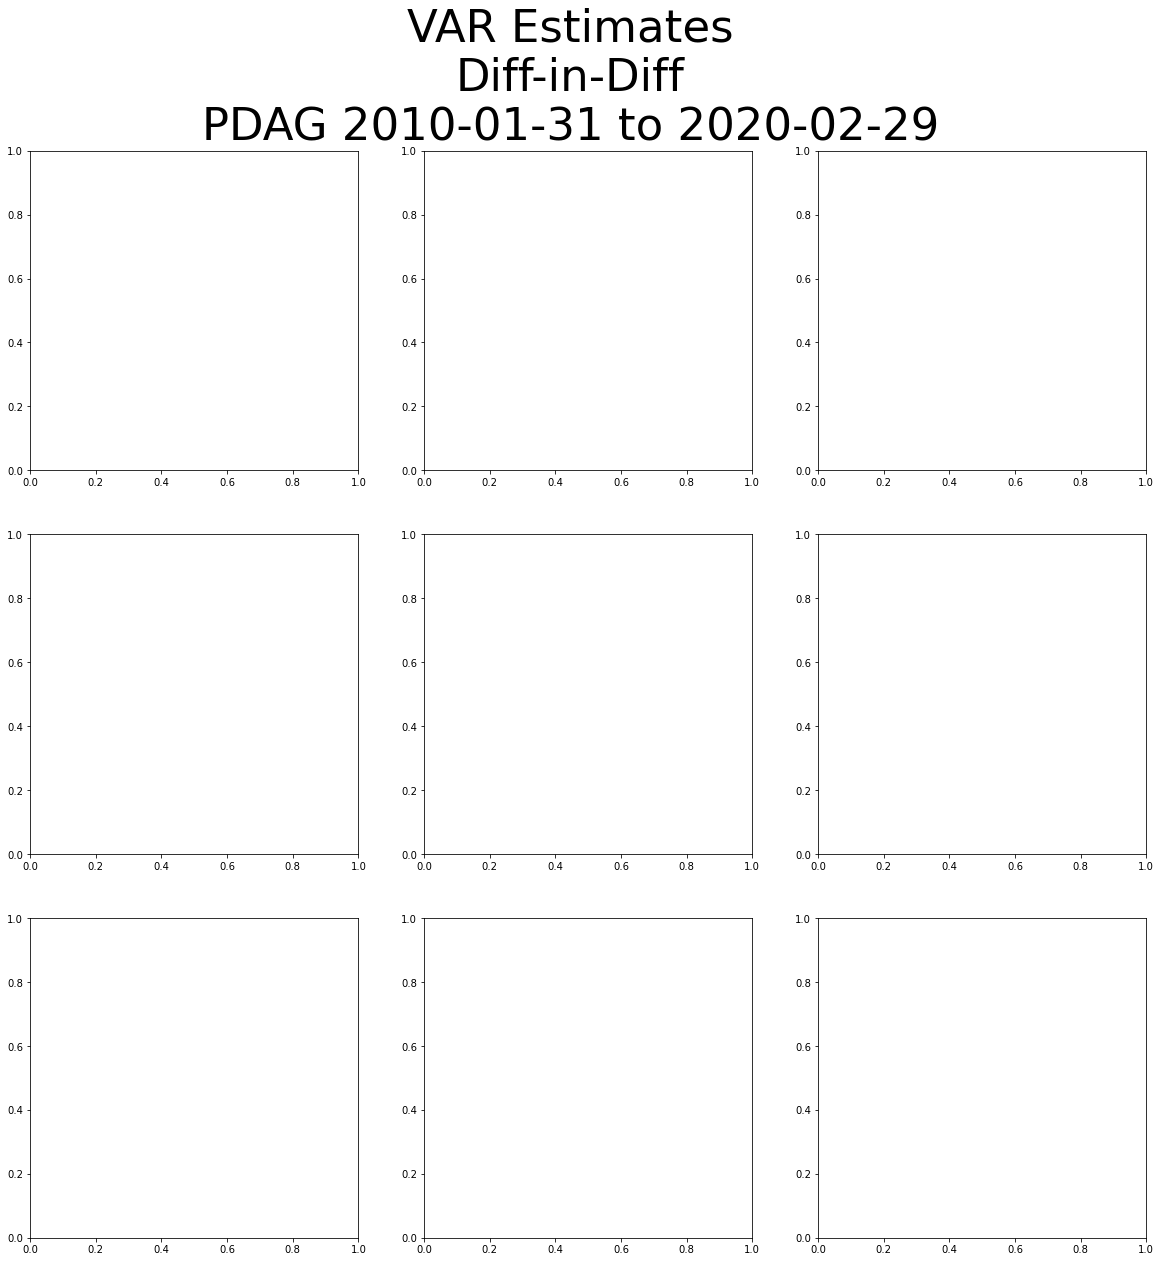

In [20]:
from datlib.DAG import *
from collections import OrderedDict
from linearmodels.system import SUR
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats


# plt.rcParams.update({"font.size":20})
# pd.to_datetime(data['Date'])
# data.set_index("Date")
# diff = "Diff"

sig_vals = [.05, .01, .001]


def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)

def rename_vars(rename_data, rename_dct):
    for key in rename_data:
        for rename_key in rename_dct:
            if rename_key in key:
                rename_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)                


                
# only estimate twice differenced data since a some variables fail to reject the null
diffs = ["Diff", "Diff-in-Diff"]
reg_dict = {}
lags = int(round(12 / year,0))

for diff in diffs:

    ## Use return_type = "pdag" to allow for endogeneity
    ##  "dag" disallows this sort ambiguity
    reg_dict[diff] = {}
    # only test the aggregated data, since the hypothesis is that:
        # 1) currency and total assets are indicate relative provision of liquidity
        # 2) loss function variables are targeted together

    plot_vars =  ["Effective Federal Funds Rate (%)",
                                        "Currency in Circulation",
                                        "Total Assets",
                                        "Loss Function",
                                         "S&P 500"]
    sig = sigs = [0.1, 0.2, 0.3]
    variants = ["orig", "stable", "parallel"]
    ci_test = "pearsonr"


    # for plot_vars in plot_vars_dct:
    i = ""
    reg_dict[diff][i] = {}
    df = data[diff]
    var_data = df[plot_vars]
    rename_vars(var_data, rename_dct)
    add_lags(var_data, lags)
    var_data.dropna(inplace=True)
    start_end_list = [(str(var_data.index[0])[:10],"2008-09-30"),
                      ("2010-01-31", "2020-02-29")]
    #                       ("2008-10-31", "2020-02-29"),
    #                        (str(var_data.index[0])[:10],"2020-02-29")]        

    # slice dfs by date range, house in dfs {}
    dfs = {}
    for start,end in start_end_list:
        dfs[start +" to " + end] =  var_data.loc[start:end].copy() 

    # use dates (key) to track dates for which hypotheses are tested
    for dates, select_df in dfs.items():
        for return_type in ["pdag"]:
            edges = {}
            dag_df = {}
            fig, ax = plt.subplots(3,3,figsize = (20,20))
            fig.suptitle("DAG Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                        fontsize = 45)

            fig_sur, ax_sur = plt.subplots(3,3,figsize = (20,20))
            fig_sur.suptitle("SUR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                        fontsize = 45)
            fig_var, ax_var = plt.subplots(3,3,figsize = (20,20))
            fig_var.suptitle("VAR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                        fontsize = 45)


In [21]:
            for x in range(len(sigs)):
                sig = sigs[x]
                edges[sig] = {}
                dag_df[sig] = {}
                for y in range(len(variants)):
                    variant = variants[y]
                    a = ax[y][x]

                    constant = False if diff == "Diff-in-Diff" else True
                    keys = [k for k in select_df if "Lag" not in k]
                    dag_df[sig][variant] = select_df[keys].dropna()
                    # construct dag, save directed edges
                    edges[sig][variant] = DAG(dag_df[sig][variant], variant, ci_test, sig, return_type)
                    # construct graphs with PC labels
                    graph_DAG(edges[sig][variant], 
                              dag_df[sig][variant], 
                              title = "",
                              fig = fig,
                              ax = a)
                    if x == 0:
                        a.set_ylabel(variant, fontsize = 30)
                    if y == len(variants) - 1:
                        a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)
                    a = ax_sur[y][x]
#                     identify sink nodes in directed dag edges, use info to detect structure of regressions
#                      additional graphs with marginal effects from SUR and VAR are constructed
                    sink_source = identify_sink_nodes(edges[sig][variant])
                    filename = i + " " + diff + "DAGOLS " + dates + " " + variant + str(sig) 
                    DAG_OLS(dag_df[sig][variant], sink_source, filename, a, diff, dates,constant = constant, return_type = return_type)    
                    if x == 0:
                        a.set_ylabel(variant, fontsize = 30)
                    if y == len(variants) - 1:
                        a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

                    a = ax_var[y][x]

    #                     filename = i + " " + diff + "DAGVAR " + dates 
                    DAG_VAR(select_df.dropna(), sink_source, filename, a, diff, dates, sig_vals,constant = constant, return_type = return_type)
                    if x == 0:
                        a.set_ylabel(variant, fontsize = 30)
                    if y == len(variants) - 1:
                        a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)


  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: Equation S regressor array is not full rank

<Figure size 432x288 with 0 Axes>